# NFL Passrush/Blocker Section 4 (of n)
# EDA (and Modeling?)

#### Libraries Used

In [1]:
import nfl_acquire_and_prep as acquire
import nfl_use_metrics as use

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

#### Use only weeks 1-6 for eda and building, reserve weeks 7 and 8 for testing

In [2]:
games = acquire.games()

In [3]:
train_games = games[games.week < 7].game
test_games = games[games.week > 6].game

#### Load first week to explore with

In [4]:
df = pd.read_csv('metric_results_weeks_1_through_8.csv')

In [5]:
train = df[df.game.isin(train_games)]

----

# 1. Aggregate by Pass Rusher

In [6]:
p = train.copy()

In [7]:
p.info()
p.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27912 entries, 0 to 27911
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   game                   27912 non-null  int64  
 1   play                   27912 non-null  int64  
 2   nflId                  27912 non-null  int64  
 3   position               27912 non-null  object 
 4   hit                    27912 non-null  int64  
 5   hurry                  27912 non-null  int64  
 6   sack                   27912 non-null  int64  
 7   pressure               27912 non-null  int64  
 8   pass_rusher_average_a  27912 non-null  float64
 9   colinearity            27912 non-null  float64
 10  pursuit_factor         27912 non-null  float64
 11  force_to_ball          27912 non-null  float64
 12  pursuit_vs_escape      27912 non-null  float64
 13  pursuit1               27912 non-null  float64
 14  pursuit2               27912 non-null  float64
 15  pu

,game,play,nflId,hit,hurry,sack,pressure,pass_rusher_average_a,colinearity,pursuit_factor,force_to_ball,pursuit_vs_escape,pursuit1,pursuit2,pursuit3_mean,pursuit3_sum,pursuit4,qb_hold_time,blocker_count
count,2.791200e+04,27912.000000,27912.000000,27912.000000,27912.000000,27912.000000,27912.000000,27912.000000,27912.000000,27912.000000,27912.000000,27912.000000,27912.000000,27912.000000,27912.000000,27912.000000,27912.000000,27912.000000,27912.000000
mean,2.021096e+09,2155.057036,45178.274864,0.022822,0.078282,0.016050,0.117154,1.989176,0.653472,0.655153,146.214814,-0.033807,-3.164053,-0.022148,1.302899,-0.780001,0.615591,3.086450,1.267663
std,4.578247e+03,1224.763771,4880.800973,0.149338,0.268619,0.125672,0.321609,0.640718,0.239655,0.256099,71.886674,0.114204,2.124589,0.118187,0.927866,3.643041,0.955413,1.124468,0.618678
min,2.021091e+09,54.000000,33131.000000,0.000000,0.000000,0.000000,0.000000,0.173500,-0.551000,-0.834100,-230.590000,-0.906100,-8.000000,-1.962200,0.026000,-43.513800,-0.890200,0.500000,0.000000
25%,2.021092e+09,1119.250000,42382.000000,0.000000,0.000000,0.000000,0.000000,1.526275,0.508675,0.538600,104.959175,-0.108600,-4.777375,-0.094900,0.698375,-2.576750,-0.010625,2.300000,1.000000
50%,2.021093e+09,2153.000000,44880.000000,0.000000,0.000000,0.000000,0.000000,1.908000,0.696600,0.712300,149.185950,-0.032600,-3.472300,-0.022200,1.081750,-0.610500,0.393800,2.800000,1.000000
75%,2.021101e+09,3175.000000,47854.000000,0.000000,0.000000,0.000000,0.000000,2.384025,0.846200,0.840200,192.212825,0.047325,-1.778475,0.056625,1.630225,1.543125,0.975125,3.500000,2.000000
max,2.021102e+09,5223.000000,53999.000000,1.000000,1.000000,1.000000,1.000000,5.234200,0.998100,0.999600,502.934200,0.402600,4.454900,0.616500,10.510400,13.314900,9.755900,9.800000,4.000000


In [8]:
p_count = p.groupby('nflId').game.count()

In [9]:
p = p.groupby('nflId').mean()

In [10]:
p = pd.merge(p, p_count, on = 'nflId').rename(columns = {'game_x':'game','game_y':'play_count'})

In [11]:
p.head()

,game,play,hit,hurry,sack,pressure,pass_rusher_average_a,colinearity,pursuit_factor,force_to_ball,pursuit_vs_escape,pursuit1,pursuit2,pursuit3_mean,pursuit3_sum,pursuit4,qb_hold_time,blocker_count,play_count
nflId,,,,,,,,,,,,,,,,,,,
33131,2.021096e+09,2160.524390,0.036585,0.073171,0.000000,0.109756,1.644987,0.691140,0.618427,126.168705,-0.110096,-1.639753,-0.110207,0.845412,-3.271469,0.095535,3.071341,1.536585,164
34465,2.021095e+09,2145.611111,0.000000,0.000000,0.000000,0.000000,3.053483,0.598528,0.615761,158.912294,0.047961,-4.187511,0.057739,1.593628,1.703544,1.039961,3.116667,0.722222,18
34654,2.021092e+09,3054.750000,0.000000,0.000000,0.000000,0.000000,3.347875,0.960950,0.731625,197.467750,0.016525,-5.843975,0.030975,1.199850,0.496025,0.621700,2.050000,0.250000,4
34777,2.021096e+09,2323.365385,0.019231,0.038462,0.000000,0.057692,1.820217,0.663442,0.605444,146.955967,-0.103146,-2.265362,-0.086035,1.302354,-2.308585,0.541600,2.788462,1.326923,52
35441,2.021096e+09,2084.808642,0.024691,0.061728,0.006173,0.092593,1.585749,0.671510,0.642786,130.293239,-0.079035,-2.575928,-0.062706,1.265891,-1.829806,0.538965,2.993827,1.524691,162


Check on positions - do they vary?

In [12]:
# nflIds = df1_m.nflId.unique()

In [13]:
# for player in nflIds:
#     print(player)
#     x = df1_m[df1_m.nflId == player]
#     print(x.position,'\n---')

Yes, positions vary. So need to combine official position with play counts to find those OLBs who mostly pass rush.

In [14]:
players = acquire.players()

Merge the original dataframe with the new to check on position vs play count.

In [15]:
p = pd.merge(p, players, on = 'nflId')

In [16]:
# d = train_cm[['officialPosition','play_count']]
# d[d.officialPosition == 'OLB'].hist()
# d.groupby('officialPosition')
# sns.relplot(data = d, x = 'officialPosition',y = 'play_count')

For OLB I am going to cut off at 25, which should get rid of most blitzes

Add all d linemen and OLBs above a certain play count threshold

In [17]:
p_olb = p[(p.officialPosition == 'OLB') & (p.play_count > 25)]

In [18]:
p = p[p.officialPosition.isin(['DE','NT','DT'])]

In [19]:
p = pd.concat([p,p_olb])

Let's filter out those with less than a certain number of plays

In [20]:
# (train_cm.play_count.describe(),
# train_cm.play_count.hist(bins = 45))

In [21]:
p.head(2)

,nflId,game,play,hit,hurry,sack,pressure,pass_rusher_average_a,colinearity,pursuit_factor,force_to_ball,pursuit_vs_escape,pursuit1,pursuit2,pursuit3_mean,pursuit3_sum,pursuit4,qb_hold_time,blocker_count,play_count,height,weight,officialPosition,displayName
0,33131,2.021096e+09,2160.524390,0.036585,0.073171,0.0,0.109756,1.644987,0.691140,0.618427,126.168705,-0.110096,-1.639753,-0.110207,0.845412,-3.271469,0.095535,3.071341,1.536585,164,80,300,DE,Calais Campbell
3,34777,2.021096e+09,2323.365385,0.019231,0.038462,0.0,0.057692,1.820217,0.663442,0.605444,146.955967,-0.103146,-2.265362,-0.086035,1.302354,-2.308585,0.541600,2.788462,1.326923,52,75,310,NT,Steve McLendon


In [22]:
p = p[['displayName', 'hit', 'hurry', 'sack', 'pressure',
       'pass_rusher_average_a', 'colinearity', 'pursuit_factor',
       'force_to_ball', 'pursuit_vs_escape', 'pursuit1', 'pursuit2',
       'pursuit3_mean', 'pursuit3_sum', 'pursuit4','play_count']]

In [23]:
p = p.rename(columns = {'displayName':'name'}).set_index('name')

## !!!! HYPOTHESIS TESTING NOW !!!!

# 2. Aggregate by Pass Blocker

##### Note: 1 pass rusher per blocker, potentially multiple pass blockers per pass rusher

Create a row for each pass blocker indicated in the manufactured dataframes

In [24]:
# Create empty dataframe
blocker_stats = []

for row in train.index:
    if train.pass_blockers.iloc[row] == '[]':
        continue
    else:
        blockers = re.findall(r'\d{5}', df.pass_blockers.iloc[row])
        
        for blocker in blockers:
            row_blockers = train.iloc[row].to_dict()
            row_blockers['pass_blocker'] = blocker
            blocker_stats.append(row_blockers)

In [25]:
blocker_stats = pd.DataFrame(blocker_stats).drop(columns = ['pass_blockers','blocker_count']).rename(columns = {'nflId':'pass_rusher'}).astype({'pass_blocker':int})

In [26]:
blocker_stats.head()

,game,play,pass_rusher,position,hit,hurry,sack,pressure,pass_rusher_average_a,colinearity,pursuit_factor,force_to_ball,pursuit_vs_escape,pursuit1,pursuit2,pursuit3_mean,pursuit3_sum,pursuit4,qb_hold_time,pass_blocker
0,2021090900,97,42403,ROLB,0,1,0,1,2.5479,0.8340,0.8895,238.3558,0.0799,-7.1719,0.1449,2.9268,4.7824,2.2977,3.4,42377
1,2021090900,97,44955,DRT,0,0,0,0,1.3261,0.3828,0.1758,18.2900,-0.1393,-0.7108,-0.1279,1.1878,-4.2197,0.2978,3.4,40151
2,2021090900,97,44955,DRT,0,0,0,0,1.3261,0.3828,0.1758,18.2900,-0.1393,-0.7108,-0.1279,1.1878,-4.2197,0.2978,3.4,42404
3,2021090900,97,53441,LILB,0,1,0,1,2.8409,0.7342,0.9013,251.3415,-0.0701,-4.8279,0.0278,2.6664,0.9184,1.8429,3.4,46163
4,2021090900,97,53441,LILB,0,1,0,1,2.8409,0.7342,0.9013,251.3415,-0.0701,-4.8279,0.0278,2.6664,0.9184,1.8429,3.4,52421


In [27]:
blocker_stats = blocker_stats[['game',
                               'play',
                               'pass_blocker',
                               'pass_rusher',
                               'position',
                               'hit',
                               'hurry',
                               'sack',
                               'pressure',
                               'pass_rusher_average_a',
                               'colinearity',
                               'pursuit_factor',
                               'pursuit_vs_escape',
                               'pursuit1',
                               'pursuit2',
                               'pursuit3_mean',
                               'pursuit3_sum',
                               'pursuit4',
                               'qb_hold_time']]

In [28]:
scout_pass_block = acquire.scout_pass_block()
scout_pass_block.head()

,game,play,nflId,position,rusher_blocked,block_type,backfield_block,beaten_by_pass_rusher,hit_allowed,hurry_allowed,sack_allowed,block_fail
4,2021090900,97,40151,C,44955,SW,0,0,0,0,0,0
7,2021090900,97,42377,LT,42403,PP,0,0,0,1,0,1
9,2021090900,97,42404,LG,44955,PP,0,0,0,0,0,0
16,2021090900,97,46163,RG,53441,SW,0,0,0,1,0,1
18,2021090900,97,52421,RT,53441,PP,0,0,0,1,0,1


In [29]:
blocker_stats = pd.merge(blocker_stats, scout_pass_block, left_on = ['game','play','pass_blocker'], right_on = ['game','play','nflId'])

In [30]:
blocker_stats.head()

,game,play,pass_blocker,pass_rusher,position_x,hit,hurry,sack,pressure,pass_rusher_average_a,colinearity,pursuit_factor,pursuit_vs_escape,pursuit1,pursuit2,pursuit3_mean,pursuit3_sum,pursuit4,qb_hold_time,nflId,position_y,rusher_blocked,block_type,backfield_block,beaten_by_pass_rusher,hit_allowed,hurry_allowed,sack_allowed,block_fail
0,2021090900,97,42377,42403,ROLB,0,1,0,1,2.5479,0.8340,0.8895,0.0799,-7.1719,0.1449,2.9268,4.7824,2.2977,3.4,42377,LT,42403,PP,0,0,0,1,0,1
1,2021090900,97,40151,44955,DRT,0,0,0,0,1.3261,0.3828,0.1758,-0.1393,-0.7108,-0.1279,1.1878,-4.2197,0.2978,3.4,40151,C,44955,SW,0,0,0,0,0,0
2,2021090900,97,42404,44955,DRT,0,0,0,0,1.3261,0.3828,0.1758,-0.1393,-0.7108,-0.1279,1.1878,-4.2197,0.2978,3.4,42404,LG,44955,PP,0,0,0,0,0,0
3,2021090900,97,46163,53441,LILB,0,1,0,1,2.8409,0.7342,0.9013,-0.0701,-4.8279,0.0278,2.6664,0.9184,1.8429,3.4,46163,RG,53441,SW,0,0,0,1,0,1
4,2021090900,97,52421,53441,LILB,0,1,0,1,2.8409,0.7342,0.9013,-0.0701,-4.8279,0.0278,2.6664,0.9184,1.8429,3.4,52421,RT,53441,PP,0,0,0,1,0,1


In [31]:
for i in blocker_stats.index:
    if blocker_stats.pass_rusher[i] != blocker_stats.rusher_blocked[i]:
        print(i)

In [32]:
pp = players[['nflId','displayName']]
blocker_stats = blocker_stats.replace(pp.set_index('nflId')['displayName'])

In [33]:
b_play_count = blocker_stats.groupby('pass_blocker').game.count()

In [34]:
b = blocker_stats.groupby('pass_blocker').mean().drop(columns = ['game','play'])

In [35]:
b['play_count'] = b_play_count

In [36]:
b.columns

Index(['hit', 'hurry', 'sack', 'pressure', 'pass_rusher_average_a',
       'colinearity', 'pursuit_factor', 'pursuit_vs_escape', 'pursuit1',
       'pursuit2', 'pursuit3_mean', 'pursuit3_sum', 'pursuit4', 'qb_hold_time',
       'backfield_block', 'beaten_by_pass_rusher', 'hit_allowed',
       'hurry_allowed', 'sack_allowed', 'block_fail', 'play_count'],
      dtype='object')

In [37]:
b = b[['hit', 'hurry', 'sack', 'pressure', 'beaten_by_pass_rusher', 'hit_allowed',
       'hurry_allowed', 'sack_allowed', 'block_fail','pass_rusher_average_a',
       'colinearity', 'pursuit_factor', 'pursuit_vs_escape', 'pursuit1',
       'pursuit2', 'pursuit3_mean', 'pursuit3_sum', 'pursuit4', 'play_count']]

In [38]:
# 32 * 6 = 192, so this approximates starting blockers
len(b[b.play_count > 50])

193

In [39]:
b = b[b.play_count > 50]

In [40]:
b.head()

,hit,hurry,sack,pressure,beaten_by_pass_rusher,hit_allowed,hurry_allowed,sack_allowed,block_fail,pass_rusher_average_a,colinearity,pursuit_factor,pursuit_vs_escape,pursuit1,pursuit2,pursuit3_mean,pursuit3_sum,pursuit4,play_count
pass_blocker,,,,,,,,,,,,,,,,,,,
A.J. Cann,0.028302,0.075472,0.000000,0.103774,0.028302,0.009434,0.075472,0.009434,0.122642,1.794718,0.636131,0.675428,-0.067333,-2.808708,-0.052387,1.110113,-1.685183,0.365148,106
Alejandro Villanueva,0.045226,0.085427,0.020101,0.150754,0.070352,0.030151,0.070352,0.025126,0.195980,2.101052,0.566614,0.631196,-0.017336,-3.290791,-0.006718,1.491273,-0.415864,0.823268,199
Alex Cappa,0.021186,0.050847,0.004237,0.076271,0.042373,0.016949,0.038136,0.004237,0.101695,1.729125,0.631251,0.716878,-0.080337,-2.690314,-0.069170,1.337849,-1.759218,0.576243,236
Alex Leatherwood,0.028436,0.080569,0.023697,0.132701,0.142180,0.033175,0.052133,0.018957,0.246445,2.256162,0.701600,0.662518,0.011462,-3.780397,0.019140,1.328825,0.374845,0.716146,211
Alex Mack,0.012579,0.031447,0.006289,0.050314,0.018868,0.006289,0.006289,0.006289,0.037736,1.630562,0.564847,0.644007,-0.098752,-1.996291,-0.085855,1.071142,-2.644982,0.278645,159


### Side quest - how different are the metrics from the pass rusher compared to scout?
> It appears that the original stats are higher, which seems to make sense since multiple pass blockers per pass rusher - actually think about this as well as the metric of old vs new

In [42]:
b = b.reset_index()

blocker = {}

for i in b.index:
    diffs = {}
    if b.hit.iloc[i] != b.hit_allowed.iloc[i]:
        diffs['hit'] = (b.hit.iloc[i] - b.hit_allowed.iloc[i])
        #hit_disparity.append({'hit':b.pass_blocker.iloc[i]})
    if b.hurry.iloc[i] != b.hurry_allowed.iloc[i]:
        diffs['hurry'] = (b.hurry.iloc[i] - b.hurry_allowed.iloc[i])
        #hurry_disparity.append({'hurry':b.pass_blocker.iloc[i]})
    if b.sack.iloc[i] != b.sack_allowed.iloc[i]:
        diffs['sack'] = (b.sack.iloc[i] - b.sack_allowed.iloc[i])
        #sack_disparity.append({'sack':b.pass_blocker.iloc[i]})
    if b.pressure.iloc[i] != b.block_fail.iloc[i]:
        diffs['pressure'] = (b.pressure.iloc[i] - b.block_fail.iloc[i])
        #pressure_v_block_fail.append({'pressure':b.pass_blocker.iloc[i]})
        
    blocker[f'{b.pass_blocker.iloc[i]}'] = diffs

array([[<AxesSubplot:title={'center':'hit'}>,
        <AxesSubplot:title={'center':'sack'}>],
       [<AxesSubplot:title={'center':'pressure'}>,
        <AxesSubplot:title={'center':'hurry'}>]], dtype=object)

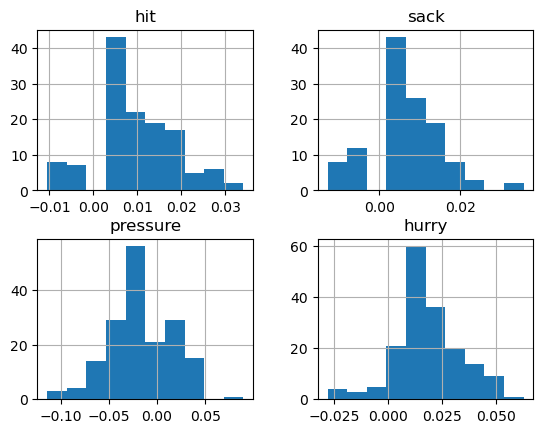

In [45]:
b2.T.hist()

In [47]:
b2 = pd.DataFrame(blocker)

# *!!!Now hypothjesis test that any of the metrics are predictive of bad blocking!!!*

# 3. Aggregate by Play

In [65]:
plays = train.copy()

Count pass rushers for play:

In [66]:
pass_rusher_count = plays.groupby(['game','play']).nflId.count()

In [67]:
pass_rusher_count

game        play
2021090900  97      5
            137     5
            187     4
            282     5
            349     5
                   ..
2021101800  3849    4
            3890    4
            3914    4
            3976    4
            3998    4
Name: nflId, Length: 6578, dtype: int64

Count pass blockers in play:

In [68]:
pass_blocker_count = plays.groupby(['game','play']).blocker_count.sum()

Get averages for play to merge the above two dfs into

In [69]:
plays = plays.groupby(['game','play']).mean() 

In [70]:
plays

nflId   hit  hurry  sack  pressure  pass_rusher_average_a  \
game       play                                                                
2021090900 97    47113.2  0.00   0.80   0.0      0.80               1.989220   
           137   42102.2  0.00   0.00   0.0      0.00               1.900160   
           187   38891.0  0.00   0.00   0.0      0.00               2.359750   
           282   41091.6  0.00   0.00   0.0      0.00               1.700380   
           349   39495.8  0.20   0.20   0.0      0.40               2.298720   
...                  ...   ...    ...   ...       ...                    ...   
2021101800 3849  44577.0  0.00   0.00   0.0      0.00               1.858400   
           3890  45978.5  0.00   0.00   0.0      0.00               2.078100   
           3914  44577.0  0.25   0.25   0.0      0.50               1.974375   
           3976  47254.0  0.25   0.00   0.0      0.25               1.756725   
           3998  44577.0  0.00   0.25   0.0      0.25               2.222075   

                 colinearity  pursuit_factor  force_to_ball  \
game       play                                               
2021090900 97       0.659080        0.690680     153.759880   
           137      0.616900        0.769380     180.303820   
           187      0.790300        0.875725     248.084375   
           282      0.679340        0.663120     126.998060   
           349      0.901380        0.839240     223.087280   
...                      ...             ...            ...   
2021101800 3849     0.559150        0.715450     135.328550   
           3890     0.375225        0.820925     191.740750   
           3914     0.732100        0.802625     186.408175   
           3976     0.700675        0.627900     118.764300   
           3998     0.675525        0.679825     163.152525   

                 pursuit_vs_escape  pursuit1  pursuit2  pursuit3_mean  \
game       play                                                         
2021090900 97            -0.043060 -4.396020  0.011220       2.500060   
           137            0.028480 -4.549740  0.044860       2.696220   
           187           -0.071150 -3.800225 -0.108850       1.422275   
           282           -0.034020 -2.420240 -0.025840       0.885360   
           349            0.006700 -4.202540 -0.038660       1.135260   
...                            ...       ...       ...            ...   
2021101800 3849          -0.024850 -3.238825 -0.011625       1.389500   
           3890          -0.032500 -3.603425  0.004350       1.541675   
           3914          -0.004925 -3.680850  0.002825       0.855725   
           3976           0.023075 -3.343775  0.029450       1.156750   
           3998           0.013450 -4.233275  0.019025       0.962975   

                 pursuit3_sum  pursuit4  qb_hold_time  blocker_count  
game       play                                                       
2021090900 97        0.371160  1.732040           3.4           1.00  
           137       1.076660  1.946400           2.5           1.00  
           187      -2.286050  0.544300           2.2           1.25  
           282      -0.800860  0.098120           3.2           1.40  
           349      -0.966540  0.392640           2.6           1.40  
...                       ...       ...           ...            ...  
2021101800 3849     -0.313700  0.717000           2.8           1.25  
           3890      0.074250  0.810375           1.8           1.25  
           3914      0.132475  0.128900           4.8           1.25  
           3976      0.941900  0.535425           3.3           1.25  
           3998      0.552400  0.352250           3.0           1.25  

[6578 rows x 17 columns]

In [71]:
plays = plays.drop(columns = ['nflId','blocker_count'])

In [72]:
plays['blocker_count'] = pass_blocker_count

In [73]:
plays['pass_rusher_count'] = pass_rusher_count

In [74]:
plays

hit  hurry  sack  pressure  pass_rusher_average_a  \
game       play                                                       
2021090900 97    0.00   0.80   0.0      0.80               1.989220   
           137   0.00   0.00   0.0      0.00               1.900160   
           187   0.00   0.00   0.0      0.00               2.359750   
           282   0.00   0.00   0.0      0.00               1.700380   
           349   0.20   0.20   0.0      0.40               2.298720   
...               ...    ...   ...       ...                    ...   
2021101800 3849  0.00   0.00   0.0      0.00               1.858400   
           3890  0.00   0.00   0.0      0.00               2.078100   
           3914  0.25   0.25   0.0      0.50               1.974375   
           3976  0.25   0.00   0.0      0.25               1.756725   
           3998  0.00   0.25   0.0      0.25               2.222075   

                 colinearity  pursuit_factor  force_to_ball  \
game       play                                               
2021090900 97       0.659080        0.690680     153.759880   
           137      0.616900        0.769380     180.303820   
           187      0.790300        0.875725     248.084375   
           282      0.679340        0.663120     126.998060   
           349      0.901380        0.839240     223.087280   
...                      ...             ...            ...   
2021101800 3849     0.559150        0.715450     135.328550   
           3890     0.375225        0.820925     191.740750   
           3914     0.732100        0.802625     186.408175   
           3976     0.700675        0.627900     118.764300   
           3998     0.675525        0.679825     163.152525   

                 pursuit_vs_escape  pursuit1  pursuit2  pursuit3_mean  \
game       play                                                         
2021090900 97            -0.043060 -4.396020  0.011220       2.500060   
           137            0.028480 -4.549740  0.044860       2.696220   
           187           -0.071150 -3.800225 -0.108850       1.422275   
           282           -0.034020 -2.420240 -0.025840       0.885360   
           349            0.006700 -4.202540 -0.038660       1.135260   
...                            ...       ...       ...            ...   
2021101800 3849          -0.024850 -3.238825 -0.011625       1.389500   
           3890          -0.032500 -3.603425  0.004350       1.541675   
           3914          -0.004925 -3.680850  0.002825       0.855725   
           3976           0.023075 -3.343775  0.029450       1.156750   
           3998           0.013450 -4.233275  0.019025       0.962975   

                 pursuit3_sum  pursuit4  qb_hold_time  blocker_count  \
game       play                                                        
2021090900 97        0.371160  1.732040           3.4              5   
           137       1.076660  1.946400           2.5              5   
           187      -2.286050  0.544300           2.2              5   
           282      -0.800860  0.098120           3.2              7   
           349      -0.966540  0.392640           2.6              7   
...                       ...       ...           ...            ...   
2021101800 3849     -0.313700  0.717000           2.8              5   
           3890      0.074250  0.810375           1.8              5   
           3914      0.132475  0.128900           4.8              5   
           3976      0.941900  0.535425           3.3              5   
           3998      0.552400  0.352250           3.0              5   

                 pass_rusher_count  
game       play                     
2021090900 97                    5  
           137                   5  
           187                   4  
           282                   5  
           349                   5  
...                            ...  
2021101800 3849                  4  
           3890                  4  
           3914  

TRY COMBINING PASS RUSHERS AND PASS BLOCKERS INTO FEATURE

In [75]:
plays['pass_rusher_to_blocker_ratio'] = plays.pass_rusher_count/plays.blocker_count

In [76]:
plays = plays.drop(columns = ['blocker_count','pass_rusher_count'])

Bring in plays:

In [77]:
plays2 = acquire.plays()

In [78]:
plays2 = plays2.reset_index()

In [79]:
plays = pd.merge(plays, plays2, on = ['game','play'])

#### This is a key dataframe for analysis!

Clean up for now:

In [80]:
#plays.columns

In [81]:
plays = plays[['quarter', 'down', 'yds_togo','seconds_left_in_qtr', 'pass_result','play_result',
       'o_formation', 'o_personnel', 'd_in_box', 'd_personnel', 'drop_back',
       'play_action', 'coverage', 'man/zone', 'yards_to_score', 'o_score',
       'd_score', 'hit', 'hurry', 'sack', 'pressure', 'pass_rusher_average_a',
       'colinearity', 'pursuit_factor', 'force_to_ball', 'pursuit_vs_escape',
       'pursuit1', 'pursuit2', 'pursuit3_mean', 'pursuit3_sum', 'pursuit4',
       'qb_hold_time', 'pass_rusher_to_blocker_ratio']]

In [82]:
plays.head()

,quarter,down,yds_togo,seconds_left_in_qtr,pass_result,play_result,o_formation,o_personnel,d_in_box,d_personnel,drop_back,play_action,coverage,man/zone,yards_to_score,o_score,d_score,hit,hurry,sack,pressure,pass_rusher_average_a,colinearity,pursuit_factor,force_to_ball,pursuit_vs_escape,pursuit1,pursuit2,pursuit3_mean,pursuit3_sum,pursuit4,qb_hold_time,pass_rusher_to_blocker_ratio
0,1,3,2,813,I,0,SHOTGUN,"1 RB, 1 TE, 3 WR",6,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,67,0,0,0.0,0.8,0.0,0.8,1.98922,0.65908,0.690680,153.759880,-0.04306,-4.396020,0.01122,2.500060,0.37116,1.73204,3.4,1.000000
1,1,1,10,798,C,28,EMPTY,"1 RB, 2 TE, 2 WR",6,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,98,0,0,0.0,0.0,0.0,0.0,1.90016,0.61690,0.769380,180.303820,0.02848,-4.549740,0.04486,2.696220,1.07666,1.94640,2.5,1.000000
2,1,2,6,743,C,5,SHOTGUN,"0 RB, 2 TE, 3 WR",6,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,66,0,0,0.0,0.0,0.0,0.0,2.35975,0.79030,0.875725,248.084375,-0.07115,-3.800225,-0.10885,1.422275,-2.28605,0.54430,2.2,0.800000
3,1,1,10,596,I,0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone,39,0,0,0.0,0.0,0.0,0.0,1.70038,0.67934,0.663120,126.998060,-0.03402,-2.420240,-0.02584,0.885360,-0.80086,0.09812,3.2,0.714286
4,1,3,15,586,I,0,SHOTGUN,"1 RB, 1 TE, 3 WR",7,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone,44,0,0,0.2,0.2,0.0,0.4,2.29872,0.90138,0.839240,223.087280,0.00670,-4.202540,-0.03866,1.135260,-0.96654,0.39264,2.6,0.714286


Find number of tight ends:

In [83]:
te_count = []

for i in plays.index:
    match = re.search(r'(\d) TE', plays.o_personnel.iloc[i])
    if match:
        te_count_i = match.group(1)
        te_count.append(int(te_count_i))
    else:
        te_count.append(0)

In [84]:
wr_count = []

for i in plays.index:
    match = re.search(r'(\d) WR', plays.o_personnel.iloc[i])
    if match:
        wr_count_i = match.group(1)
        wr_count.append(int(wr_count_i))
    else:
        wr_count.append(0)

In [85]:
d_form = []

for i in plays.index:
    match = re.search(r'(\d) DL, (\d) LB', plays.d_personnel.iloc[i])
    if match:
        d_form_i = f'{match.group(1)}-{match.group(2)}'
        d_form.append(d_form_i)

In [86]:
db_count = []

for i in plays.index:
    match = re.search(r'(\d) DB', plays.d_personnel.iloc[i])
    if match:
        db_count_i = match.group(1)
        db_count.append(int(db_count_i))

In [87]:
plays['te_count'] = te_count
plays['wr_count'] = wr_count
plays['d_form'] = d_form
plays['db_count'] = db_count

In [88]:
plays = plays.drop(columns = ['o_personnel','d_personnel','o_formation','drop_back','coverage','man/zone','d_form'])

In [89]:
plays.head()

,quarter,down,yds_togo,seconds_left_in_qtr,pass_result,play_result,d_in_box,play_action,yards_to_score,o_score,d_score,hit,hurry,sack,pressure,pass_rusher_average_a,colinearity,pursuit_factor,force_to_ball,pursuit_vs_escape,pursuit1,pursuit2,pursuit3_mean,pursuit3_sum,pursuit4,qb_hold_time,pass_rusher_to_blocker_ratio,te_count,wr_count,db_count
0,1,3,2,813,I,0,6,0,67,0,0,0.0,0.8,0.0,0.8,1.98922,0.65908,0.690680,153.759880,-0.04306,-4.396020,0.01122,2.500060,0.37116,1.73204,3.4,1.000000,1,3,5
1,1,1,10,798,C,28,6,0,98,0,0,0.0,0.0,0.0,0.0,1.90016,0.61690,0.769380,180.303820,0.02848,-4.549740,0.04486,2.696220,1.07666,1.94640,2.5,1.000000,2,2,3
2,1,2,6,743,C,5,6,0,66,0,0,0.0,0.0,0.0,0.0,2.35975,0.79030,0.875725,248.084375,-0.07115,-3.800225,-0.10885,1.422275,-2.28605,0.54430,2.2,0.800000,2,3,5
3,1,1,10,596,I,0,6,1,39,0,0,0.0,0.0,0.0,0.0,1.70038,0.67934,0.663120,126.998060,-0.03402,-2.420240,-0.02584,0.885360,-0.80086,0.09812,3.2,0.714286,2,2,4
4,1,3,15,586,I,0,7,0,44,0,0,0.2,0.2,0.0,0.4,2.29872,0.90138,0.839240,223.087280,0.00670,-4.202540,-0.03866,1.135260,-0.96654,0.39264,2.6,0.714286,1,3,4


In [90]:
plays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6574 entries, 0 to 6573
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   quarter                       6574 non-null   int64  
 1   down                          6574 non-null   int64  
 2   yds_togo                      6574 non-null   int64  
 3   seconds_left_in_qtr           6574 non-null   int64  
 4   pass_result                   6574 non-null   object 
 5   play_result                   6574 non-null   int64  
 6   d_in_box                      6574 non-null   int64  
 7   play_action                   6574 non-null   int64  
 8   yards_to_score                6574 non-null   int64  
 9   o_score                       6574 non-null   int64  
 10  d_score                       6574 non-null   int64  
 11  hit                           6574 non-null   float64
 12  hurry                         6574 non-null   float64
 13  sac

Combine offense and defense scores

In [91]:
plays['score_diff'] = plays.o_score - plays.d_score

In [92]:
plays = plays.drop(columns = ['o_score','d_score'])

In [93]:
plays.head()

,quarter,down,yds_togo,seconds_left_in_qtr,pass_result,play_result,d_in_box,play_action,yards_to_score,hit,hurry,sack,pressure,pass_rusher_average_a,colinearity,pursuit_factor,force_to_ball,pursuit_vs_escape,pursuit1,pursuit2,pursuit3_mean,pursuit3_sum,pursuit4,qb_hold_time,pass_rusher_to_blocker_ratio,te_count,wr_count,db_count,score_diff
0,1,3,2,813,I,0,6,0,67,0.0,0.8,0.0,0.8,1.98922,0.65908,0.690680,153.759880,-0.04306,-4.396020,0.01122,2.500060,0.37116,1.73204,3.4,1.000000,1,3,5,0
1,1,1,10,798,C,28,6,0,98,0.0,0.0,0.0,0.0,1.90016,0.61690,0.769380,180.303820,0.02848,-4.549740,0.04486,2.696220,1.07666,1.94640,2.5,1.000000,2,2,3,0
2,1,2,6,743,C,5,6,0,66,0.0,0.0,0.0,0.0,2.35975,0.79030,0.875725,248.084375,-0.07115,-3.800225,-0.10885,1.422275,-2.28605,0.54430,2.2,0.800000,2,3,5,0
3,1,1,10,596,I,0,6,1,39,0.0,0.0,0.0,0.0,1.70038,0.67934,0.663120,126.998060,-0.03402,-2.420240,-0.02584,0.885360,-0.80086,0.09812,3.2,0.714286,2,2,4,0
4,1,3,15,586,I,0,7,0,44,0.2,0.2,0.0,0.4,2.29872,0.90138,0.839240,223.087280,0.00670,-4.202540,-0.03866,1.135260,-0.96654,0.39264,2.6,0.714286,1,3,4,0



---- quarter


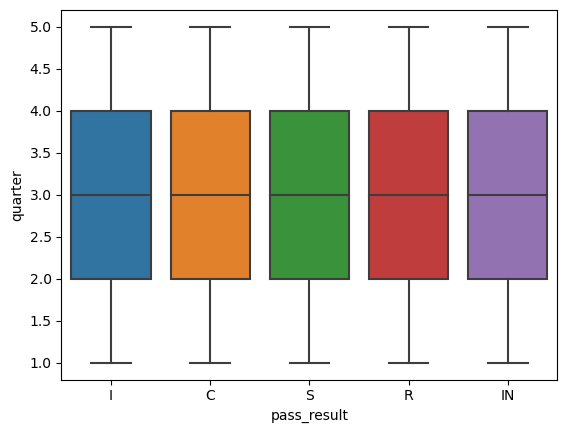


---- down


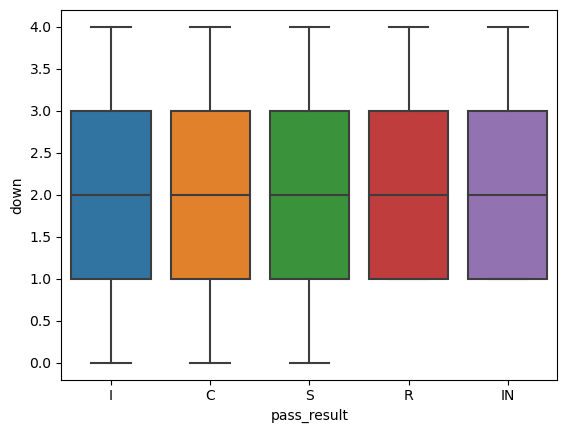


---- yds_togo


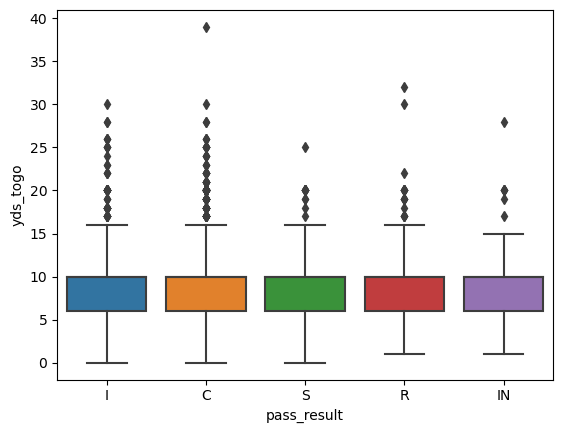


---- seconds_left_in_qtr


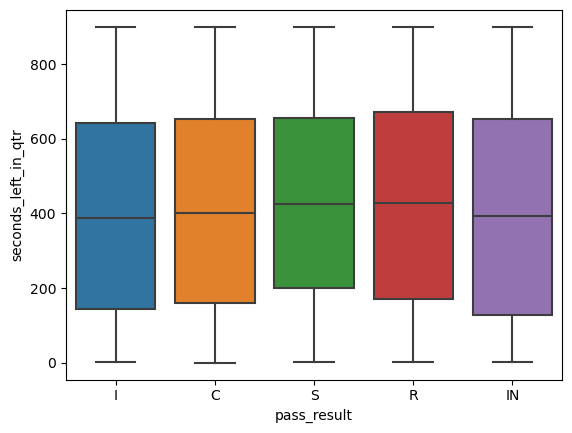


---- pass_result
N/A

---- play_result


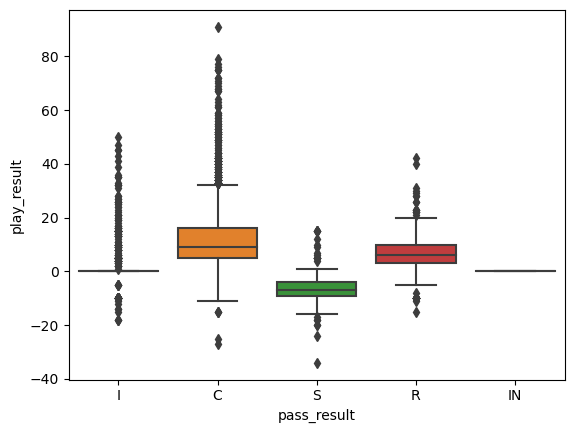


---- d_in_box


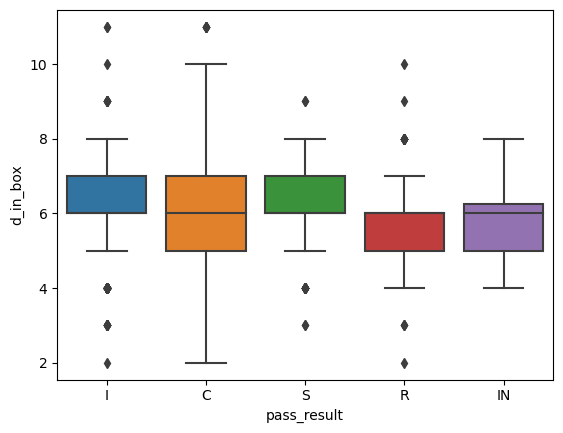


---- play_action


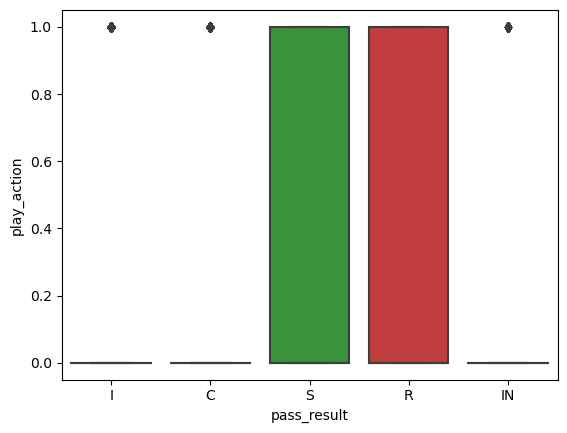


---- yards_to_score


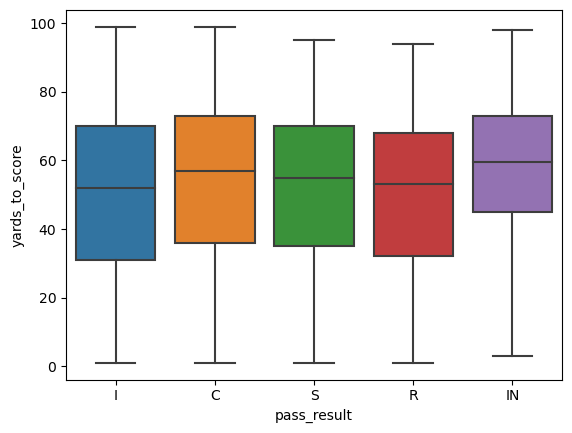


---- hit


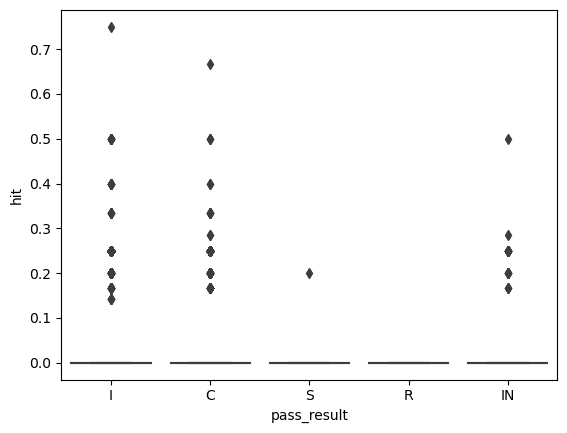


---- hurry


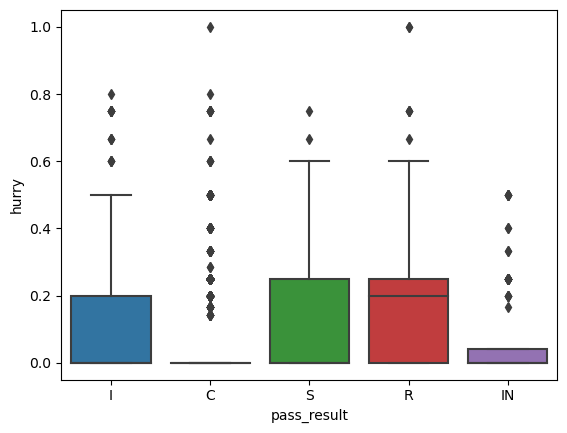


---- sack


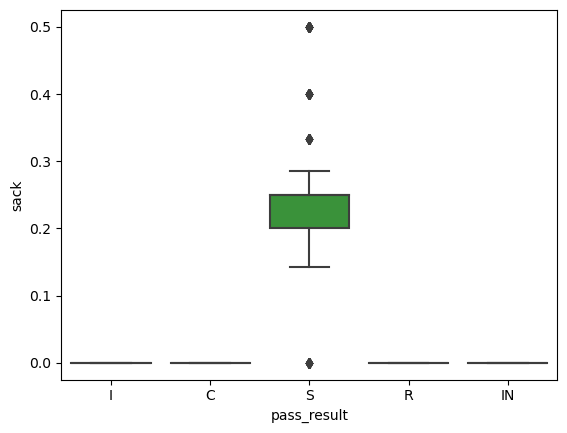


---- pressure


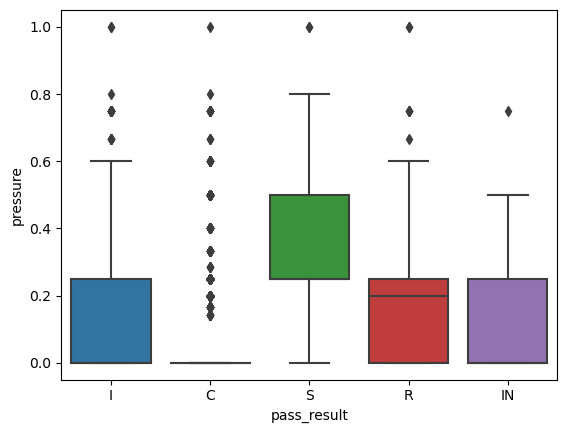


---- pass_rusher_average_a


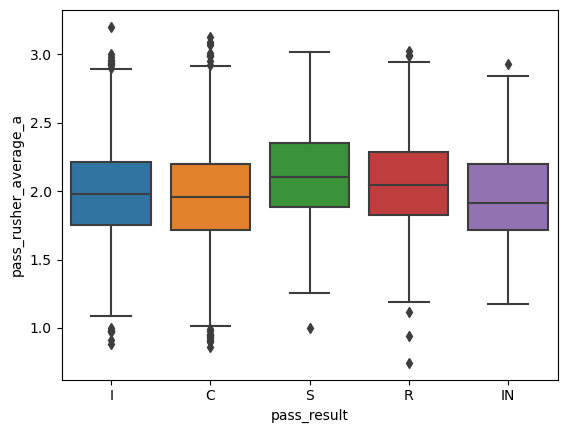


---- colinearity


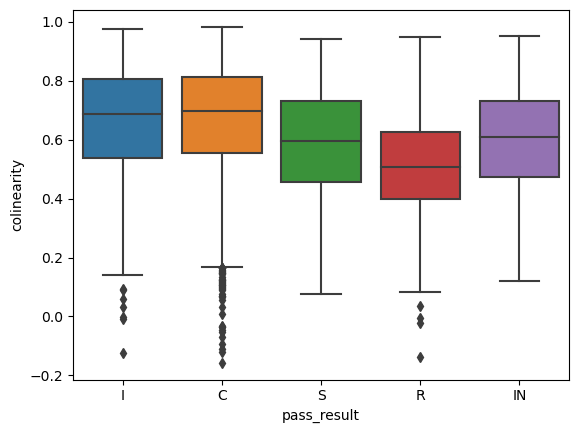


---- pursuit_factor


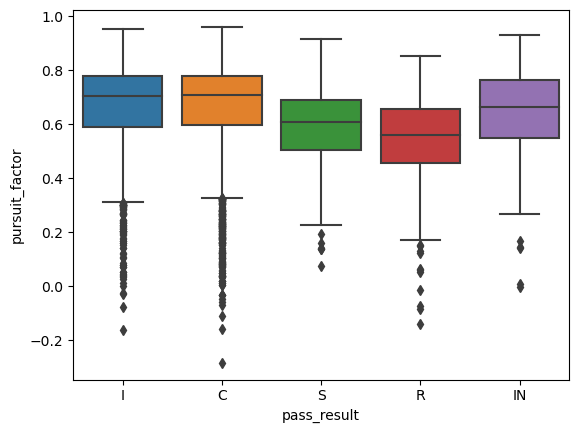


---- force_to_ball


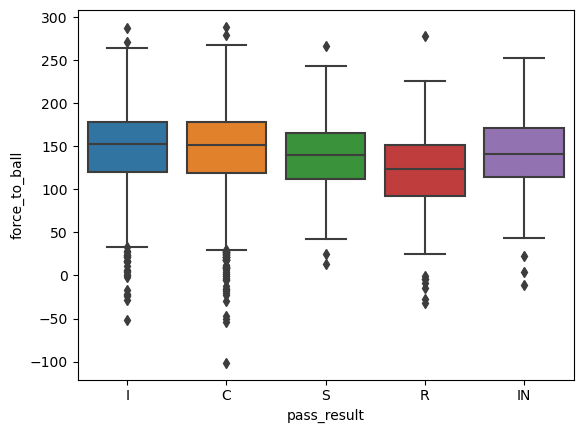


---- pursuit_vs_escape


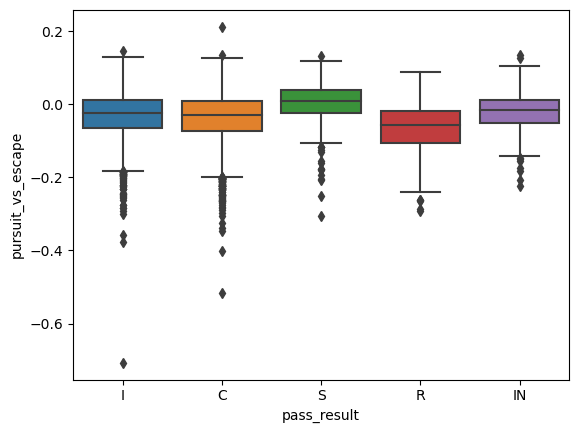


---- pursuit1


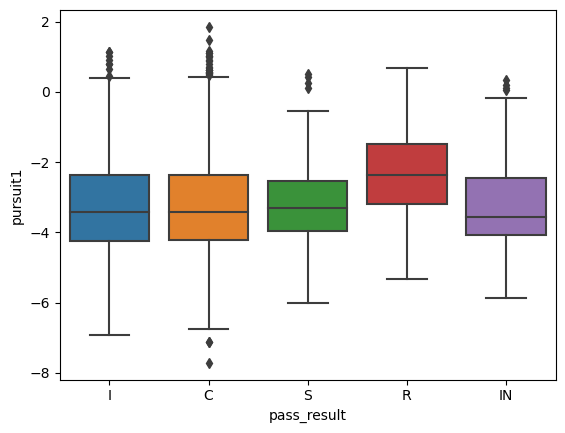


---- pursuit2


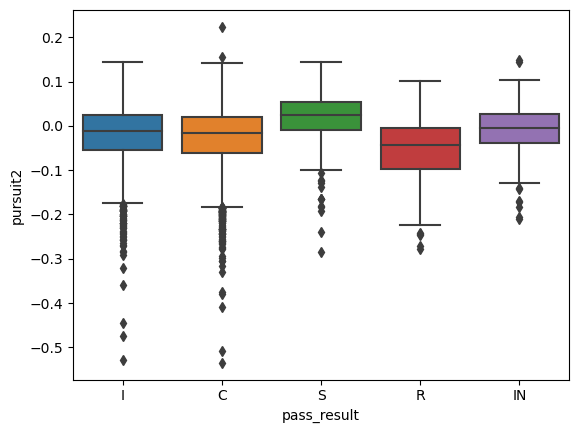


---- pursuit3_mean


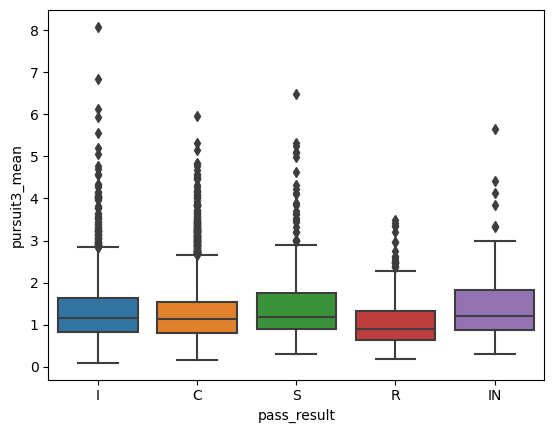


---- pursuit3_sum


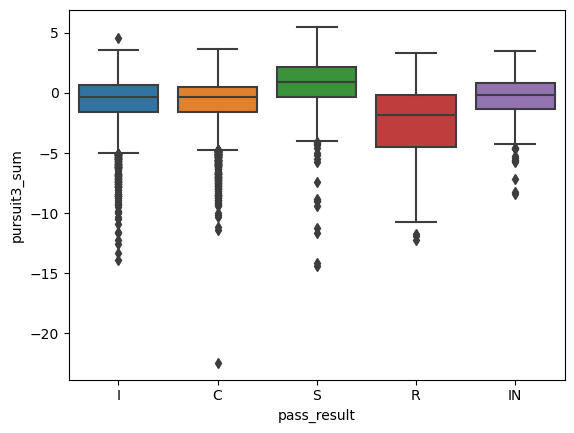


---- pursuit4


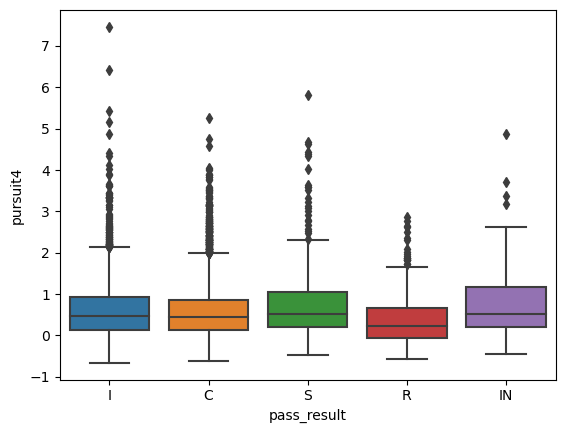


---- qb_hold_time


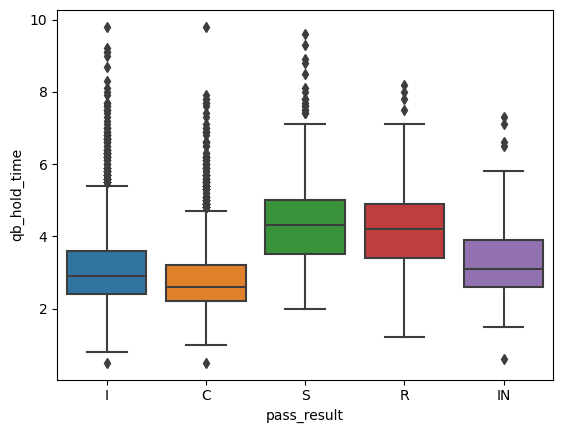


---- pass_rusher_to_blocker_ratio


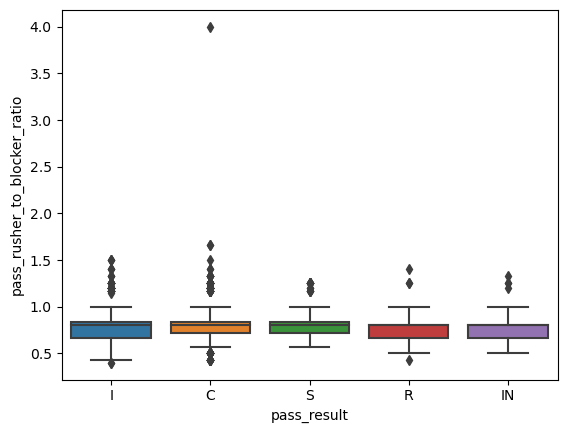


---- te_count


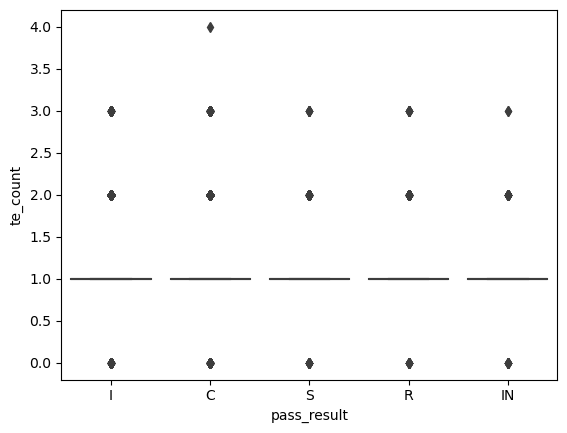


---- wr_count


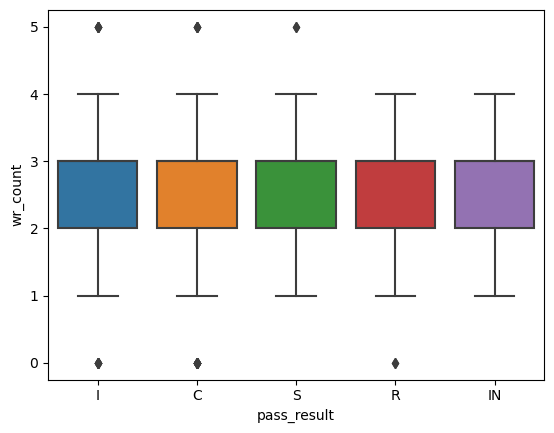


---- db_count


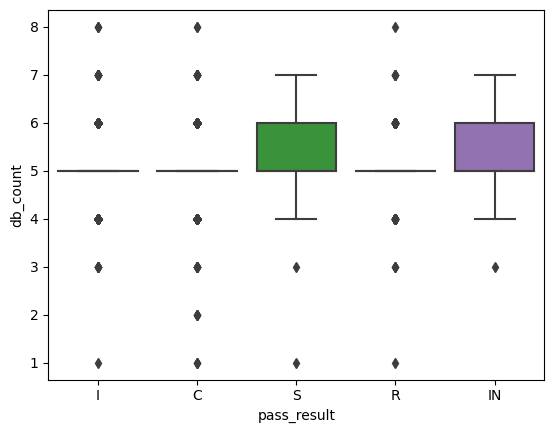


---- score_diff


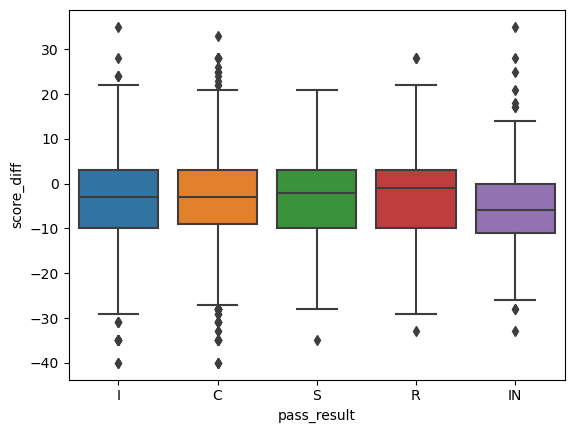

In [94]:
for i in plays.columns:
    print('\n----',i)
    if i == 'pass_result':
        print('N/A')
        continue
    else:
        sns.boxplot(x = plays.pass_result, y = plays[i])
        plt.show()

# CLUSTER OFFENSIVE FORMATIONS!

Check some stats using pass result

1. Game conditions (time and yards): quarter, down, yards to go, seconds left in quarters
2. Formations vs formations

# 2. Field - Time - Position Combination
- Close with low time
- Far with lots of time
- Etc.

In [134]:
cluster_builder = train.copy()

In [135]:
pass_rusher_count = list(cluster_builder.groupby(['game','play']).nflId.count())
pass_blocker_count = list(cluster_builder.groupby(['game','play']).blocker_count.sum())

In [136]:
cluster_builder = cluster_builder.groupby(['game','play']).mean()

In [137]:
cluster_builder['blocker_count'] = pass_blocker_count
cluster_builder['pass_rusher_count'] = pass_rusher_count
cluster_builder['pass_rusher_to_blocker_ratio'] = cluster_builder.pass_rusher_count/cluster_builder.blocker_count

In [138]:
p2 = acquire.plays()
cluster_builder = pd.merge(cluster_builder, p2, on = ['game','play'])

In [140]:
cluster_builder['te_count'] = te_count
cluster_builder['wr_count'] = wr_count
cluster_builder['d_form'] = d_form
cluster_builder['db_count'] = db_count

In [142]:
cluster_builder['score_diff'] = cluster_builder.o_score - cluster_builder.d_score

In [154]:
cluster_builder.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6574 entries, 0 to 6573
Data columns (total 54 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   game                          6574 non-null   int64  
 1   play                          6574 non-null   int64  
 2   nflId                         6574 non-null   float64
 3   hit                           6574 non-null   float64
 4   hurry                         6574 non-null   float64
 5   sack                          6574 non-null   float64
 6   pressure                      6574 non-null   float64
 7   pass_rusher_average_a         6574 non-null   float64
 8   colinearity                   6574 non-null   float64
 9   pursuit_factor                6574 non-null   float64
 10  force_to_ball                 6574 non-null   float64
 11  pursuit_vs_escape             6574 non-null   float64
 12  pursuit1                      6574 non-null   float64
 13  pur

In [143]:
cluster_builder.head()

,game,play,nflId,hit,hurry,sack,pressure,pass_rusher_average_a,colinearity,pursuit_factor,force_to_ball,pursuit_vs_escape,pursuit1,pursuit2,pursuit3_mean,pursuit3_sum,pursuit4,qb_hold_time,blocker_count,pass_rusher_count,pass_rusher_to_blocker_ratio,play_description,quarter,down,yds_togo,offense,defense,seconds_left_in_qtr,pass_result,penalty_yards,play_outcome,play_result,penalty1,penalized1,penalty2,penalized2,penalty3,penalized3,o_formation,o_personnel,d_in_box,d_personnel,drop_back,play_action,coverage,man/zone,yards_to_score,o_score,d_score,te_count,wr_count,d_form,db_count,score_diff
0,2021090900,97,47113.2,0.0,0.8,0.0,0.8,1.98922,0.65908,0.690680,153.759880,-0.04306,-4.396020,0.01122,2.500060,0.37116,1.73204,3.4,5,5,1.000000,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,813,I,0,0,0,0,0,0,0,0,0,SHOTGUN,"1 RB, 1 TE, 3 WR",6,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,67,0,0,1,3,4-2,5,0
1,2021090900,137,42102.2,0.0,0.0,0.0,0.0,1.90016,0.61690,0.769380,180.303820,0.02848,-4.549740,0.04486,2.696220,1.07666,1.94640,2.5,5,5,1.000000,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,DAL,TB,798,C,0,28,28,0,0,0,0,0,0,EMPTY,"1 RB, 2 TE, 2 WR",6,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,98,0,0,2,2,4-4,3,0
2,2021090900,187,38891.0,0.0,0.0,0.0,0.0,2.35975,0.79030,0.875725,248.084375,-0.07115,-3.800225,-0.10885,1.422275,-2.28605,0.54430,2.2,5,4,0.800000,(12:23) (Shotgun) D.Prescott pass short middle...,1,2,6,DAL,TB,743,C,0,5,5,0,0,0,0,0,0,SHOTGUN,"0 RB, 2 TE, 3 WR",6,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,66,0,0,2,3,3-3,5,0
3,2021090900,282,41091.6,0.0,0.0,0.0,0.0,1.70038,0.67934,0.663120,126.998060,-0.03402,-2.420240,-0.02584,0.885360,-0.80086,0.09812,3.2,7,5,0.714286,(9:56) D.Prescott pass incomplete deep left to...,1,1,10,DAL,TB,596,I,0,0,0,0,0,0,0,0,0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone,39,0,0,2,2,4-3,4,0
4,2021090900,349,39495.8,0.2,0.2,0.0,0.4,2.29872,0.90138,0.839240,223.087280,0.00670,-4.202540,-0.03866,1.135260,-0.96654,0.39264,2.6,7,5,0.714286,(9:46) (Shotgun) D.Prescott pass incomplete sh...,1,3,15,DAL,TB,586,I,0,0,0,0,0,0,0,0,0,SHOTGUN,"1 RB, 1 TE, 3 WR",7,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone,44,0,0,1,3,3-4,4,0


In [176]:
# Drop record 6186 (game,play = 2021101707,2181, there are no blockers
cluster_builder = cluster_builder[cluster_builder.index != 6186]

In [180]:
cluster_builder_spacetime = cluster_builder[['quarter', 'down', 'yds_togo','seconds_left_in_qtr','yards_to_score','score_diff']]

#cluster_builder_score = cluster_builder[['seconds_left_in_qtr','yards_to_score','score_diff']]

cluster_builder_formations = cluster_builder[['pass_rusher_to_blocker_ratio', 'd_in_box', 'te_count', 'wr_count', 'd_form', 'db_count']]


-----

In [147]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

A few random clusters to start:

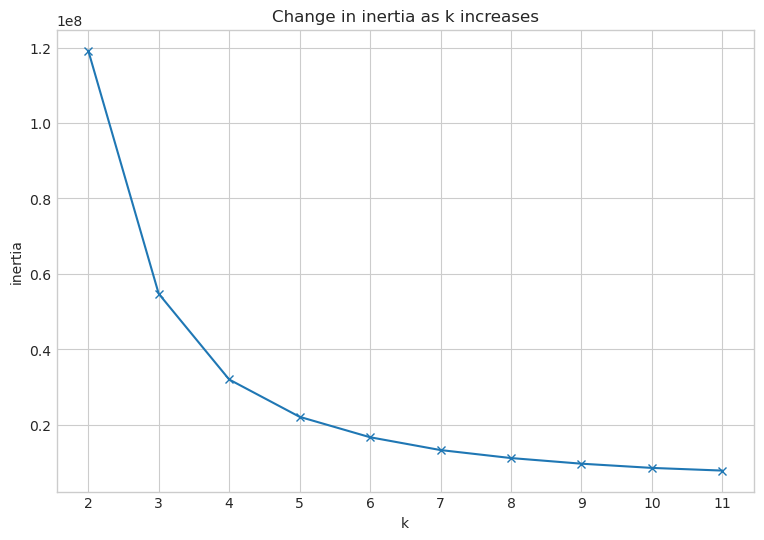

In [169]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(cluster_builder_spacetime).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [183]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(cluster_builder_spacetime)

KMeans(n_clusters=6)

In [184]:
spacetime_cluster = kmeans.labels_

In [185]:
cluster_builder['spacetime_cluster'] = spacetime_cluster

<AxesSubplot:xlabel='yds_togo', ylabel='score_diff'>

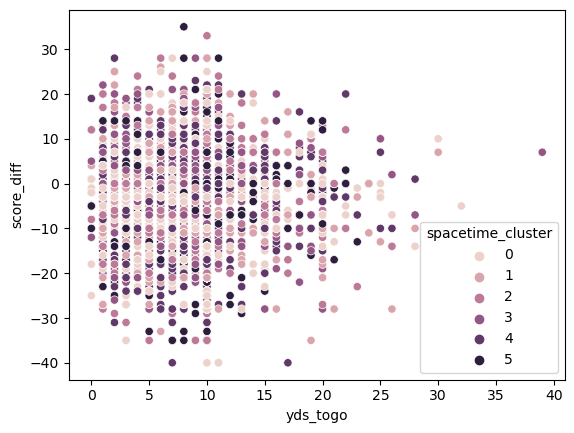

In [186]:
cluster_builder
#'yards_to_score','score_dff'
sns.scatterplot(data = cluster_builder, x = 'yds_togo',y = 'score_diff', hue = 'spacetime_cluster' )

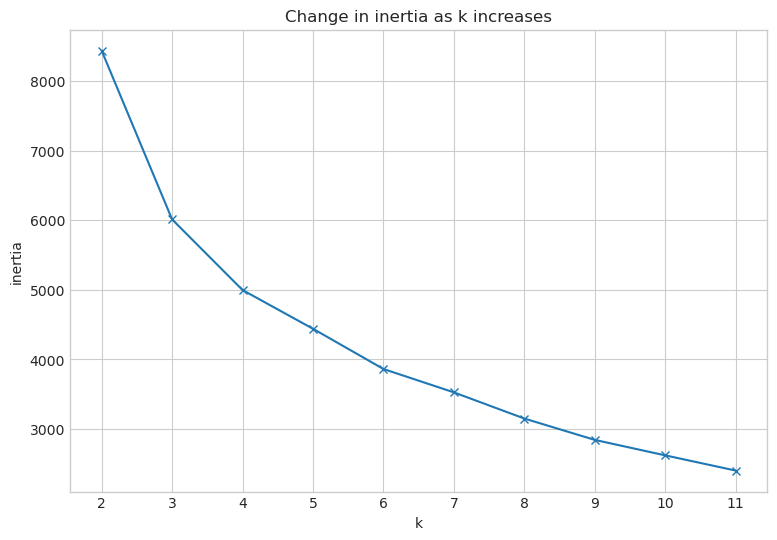

In [181]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(cluster_builder_formations.drop(columns = ['d_form'])).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [187]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(cluster_builder_formations.drop(columns = ['d_form']))

KMeans()

In [188]:
formations_cluster = kmeans.labels_

cluster_builder['formations_cluster'] = formations_cluster

<AxesSubplot:xlabel='te_count', ylabel='score_diff'>

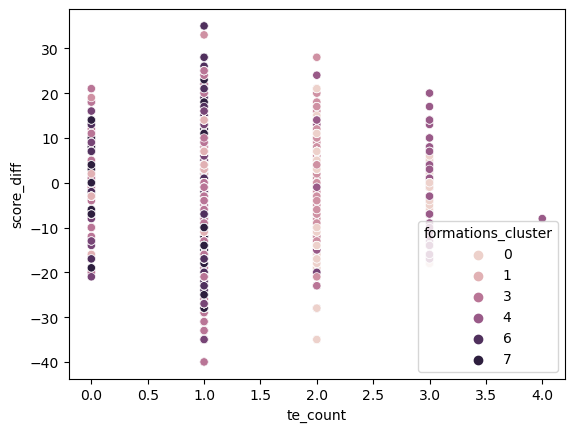

In [190]:
cluster_builder
#'yards_to_score','score_dff'
sns.scatterplot(data = cluster_builder, x = 'te_count',y = 'score_diff', hue = 'formations_cluster' )

In [191]:
cluster_builder

,game,play,nflId,hit,hurry,sack,pressure,pass_rusher_average_a,colinearity,pursuit_factor,force_to_ball,pursuit_vs_escape,pursuit1,pursuit2,pursuit3_mean,pursuit3_sum,pursuit4,qb_hold_time,blocker_count,pass_rusher_count,pass_rusher_to_blocker_ratio,play_description,quarter,down,yds_togo,offense,defense,seconds_left_in_qtr,pass_result,penalty_yards,play_outcome,play_result,penalty1,penalized1,penalty2,penalized2,penalty3,penalized3,o_formation,o_personnel,d_in_box,d_personnel,drop_back,play_action,coverage,man/zone,yards_to_score,o_score,d_score,te_count,wr_count,d_form,db_count,score_diff,spacetime_cluster,formations_cluster
0,2021090900,97,47113.2,0.00,0.80,0.0,0.80,1.989220,0.659080,0.690680,153.759880,-0.043060,-4.396020,0.011220,2.500060,0.371160,1.732040,3.4,5,5,1.000000,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,813,I,0,0,0,0,0,0,0,0,0,SHOTGUN,"1 RB, 1 TE, 3 WR",6,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,67,0,0,1,3,4-2,5,0,3,3
1,2021090900,137,42102.2,0.00,0.00,0.0,0.00,1.900160,0.616900,0.769380,180.303820,0.028480,-4.549740,0.044860,2.696220,1.076660,1.946400,2.5,5,5,1.000000,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,DAL,TB,798,C,0,28,28,0,0,0,0,0,0,EMPTY,"1 RB, 2 TE, 2 WR",6,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,98,0,0,2,2,4-4,3,0,3,0
2,2021090900,187,38891.0,0.00,0.00,0.0,0.00,2.359750,0.790300,0.875725,248.084375,-0.071150,-3.800225,-0.108850,1.422275,-2.286050,0.544300,2.2,5,4,0.800000,(12:23) (Shotgun) D.Prescott pass short middle...,1,2,6,DAL,TB,743,C,0,5,5,0,0,0,0,0,0,SHOTGUN,"0 RB, 2 TE, 3 WR",6,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,66,0,0,2,3,3-3,5,0,1,3
3,2021090900,282,41091.6,0.00,0.00,0.0,0.00,1.700380,0.679340,0.663120,126.998060,-0.034020,-2.420240,-0.025840,0.885360,-0.800860,0.098120,3.2,7,5,0.714286,(9:56) D.Prescott pass incomplete deep left to...,1,1,10,DAL,TB,596,I,0,0,0,0,0,0,0,0,0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone,39,0,0,2,2,4-3,4,0,5,0
4,2021090900,349,39495.8,0.20,0.20,0.0,0.40,2.298720,0.901380,0.839240,223.087280,0.006700,-4.202540,-0.038660,1.135260,-0.966540,0.392640,2.6,7,5,0.714286,(9:46) (Shotgun) D.Prescott pass incomplete sh...,1,3,15,DAL,TB,586,I,0,0,0,0,0,0,0,0,0,SHOTGUN,"1 RB, 1 TE, 3 WR",7,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone,44,0,0,1,3,3-4,4,0,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569,2021101800,3849,44577.0,0.00,0.00,0.0,0.00,1.858400,0.559150,0.715450,135.328550,-0.024850,-3.238825,-0.011625,1.389500,-0.313700,0.717000,2.8,5,4,0.800000,"(2:27) (No Huddle, Shotgun) J.Allen pass short...",4,1,10,BUF,TEN,147,C,0,12,12,0,0,0,0,0,0,SHOTGUN,"1 RB, 0 TE, 4 WR",4,"2 DL, 3 LB, 6 DB",TRADITIONAL,0,Cover-2,Zone,51,31,34,0,4,2-3,6,-3,4,7
6570,2021101800,3890,45978.5,0.00,0.00,0.0,0.00,2.078100,0.375225,0.820925,191.740750,-0.032500,-3.603425,0.004350,1.541675,0.074250,0.810375,1.8,5,4,0.800000,(2:00) (Shotgun) J.Allen pass short middle to ...,4,1,10,BUF,TEN,120,C,0,7,7,0,0,0,0,0,0,EMPTY,"1 RB, 0 TE, 4 WR",5,"2 DL, 3 LB, 6 DB",TRADITIONAL,0,Cover-2,Zone,39,31,34,0,4,2-3,6,-3,0,7
6571,2021101800,3914,44577.0,0.25,0.25,0.0,0.50,1.974375,0.732100,0.802625,186.408175,-0.004925,-3.680850,0.002825,0.855725,0.132475,0.128900,4.8,5,4,0.800000,(1:33) (Shotgun) J.Allen pass short right to G...,4,2,3,BUF,TEN,93,C,0,20,20,0,0,0,0,0,0,SHOTGUN,"1 RB, 0 TE, 4 WR",5,"2 DL, 3 LB, 6 DB",SCRAMBLE,0,Quarters,Zone,32,31,34,0,4,2-3,6,-3,0,7
6572,2021101800,3976,47254.0,0.25,0.00,0.0,0.25,1.756725,0.700675,0.627900,118.764300,0.023075,-3.343775,0.029450,1.156750,0.941900,0.535425,3.3,5,4,0.800000,(:44) (Shotgun) J.Allen pass incomplete short ...,4,2,6,BUF,TEN,44,I,0,0,0,0,0,0,0,0,0,SHOTGUN,"1 RB, 0 TE, 4 WR",6,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Red Zone,Other,8,31,34,0,4,3-3,5,-3,0,3


In [192]:
cluster_builder.columns

Index(['game', 'play', 'nflId', 'hit', 'hurry', 'sack', 'pressure',
       'pass_rusher_average_a', 'colinearity', 'pursuit_factor',
       'force_to_ball', 'pursuit_vs_escape', 'pursuit1', 'pursuit2',
       'pursuit3_mean', 'pursuit3_sum', 'pursuit4', 'qb_hold_time',
       'blocker_count', 'pass_rusher_count', 'pass_rusher_to_blocker_ratio',
       'play_description', 'quarter', 'down', 'yds_togo', 'offense', 'defense',
       'seconds_left_in_qtr', 'pass_result', 'penalty_yards', 'play_outcome',
       'play_result', 'penalty1', 'penalized1', 'penalty2', 'penalized2',
       'penalty3', 'penalized3', 'o_formation', 'o_personnel', 'd_in_box',
       'd_personnel', 'drop_back', 'play_action', 'coverage', 'man/zone',
       'yards_to_score', 'o_score', 'd_score', 'te_count', 'wr_count',
       'd_form', 'db_count', 'score_diff', 'spacetime_cluster',
       'formations_cluster'],
      dtype='object')

In [193]:
clustered_plays_columns = ['game', 'play', 'play_description', 'quarter', 'down', 'seconds_left_in_qtr', 'yds_togo', # Play information
                           'hit', 'hurry', 'sack', 'pressure', 'pass_result', 'play_result', # Play Outcomes
                           'pass_rusher_average_a', 'colinearity', 'pursuit_factor', 'pursuit_vs_escape', # Dynamic Metrics
                           'force_to_ball', 'pursuit1', 'pursuit2','pursuit3_mean', 'pursuit3_sum', 'pursuit4', # Derived metrics
                           'pass_rusher_to_blocker_ratio', 'o_formation', 'd_in_box', 'te_count', 'wr_count','d_form', 'db_count', 'coverage', 'man/zone', # Formation Factors
                           'drop_back', 'play_action', 'qb_hold_time', # QB Factors 
                           'yards_to_score', 'score_diff', # Score and Yardage factors
                           'spacetime_cluster', 'formations_cluster'] # Clusters

In [194]:
clustered_plays_numeric_columns = ['seconds_left_in_qtr', 'yds_togo', # Play information
                                   'hit', 'hurry', 'sack', 'pressure', 'play_result', # Play Outcomes]
                                   'pass_rusher_average_a', 'colinearity', 'pursuit_factor', 'pursuit_vs_escape', # Dynamic Metrics
                                   'force_to_ball', 'pursuit1', 'pursuit2','pursuit3_mean', 'pursuit3_sum', 'pursuit4', # Derived metrics
                                   'pass_rusher_to_blocker_ratio', 'd_in_box', 'te_count', 'wr_count', 'db_count', # Formation Factors
                                   'qb_hold_time', # QB Factors 
                                   'yards_to_score', 'score_diff', # Score and Yardage factors
                                   'spacetime_cluster', 'formations_cluster'] # Clusters                                 

In [195]:
clustered_plays_cat_columns = ['quarter', 'down',
                               'pass_result',                               
                               'o_formation', 'd_form', 'coverage', 'man/zone',
                               'drop_back', 'play_action']

In [207]:
cat_vars = clustered_plays_cat_columns
quant_vars = clustered_plays_numeric_columns
train = cluster_builder[clustered_plays_columns]

In [208]:
#target = 'play_result'
target = 'pass_result'

In [209]:
def explore_univariate(train, cat_vars, quant_vars):
    for var in cat_vars:
        explore_univariate_categorical(train, var)
        print('_________________________________________________________________')
    for col in quant_vars:
        p, descriptive_stats = explore_univariate_quant(train, col)
        plt.show(p)
        print(descriptive_stats)

def explore_bivariate(train, target, cat_vars, quant_vars):
    for cat in cat_vars:
        explore_bivariate_categorical(train, target, cat)
    for quant in quant_vars:
        explore_bivariate_quant(train, target, quant)

def explore_multivariate(train, target, cat_vars, quant_vars):
    '''
    '''
    plot_swarm_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    violin = plot_violin_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    pair = sns.pairplot(data=train, vars=quant_vars, hue=target)
    plt.show()
    plot_all_continuous_vars(train, target, quant_vars)
    plt.show()    


### Univariate

def explore_univariate_categorical(train, cat_var):
    '''
    takes in a dataframe and a categorical variable and returns
    a frequency table and barplot of the frequencies. 
    '''
    frequency_table = freq_table(train, cat_var)
    plt.figure(figsize=(2,2))
    sns.barplot(x=cat_var, y='Count', data=frequency_table, color='lightseagreen')
    plt.title(cat_var)
    plt.show()
    print(frequency_table)

def explore_univariate_quant(train, quant_var):
    '''
    takes in a dataframe and a quantitative variable and returns
    descriptive stats table, histogram, and boxplot of the distributions. 
    '''
    descriptive_stats = train[quant_var].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train[quant_var], color='lightseagreen')
    p = plt.title(quant_var)

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train[quant_var])
    p = plt.title(quant_var)
    return p, descriptive_stats

def freq_table(train, cat_var):
    '''
    for a given categorical variable, compute the frequency count and percent split
    and return a dataframe of those values along with the different classes. 
    '''
    class_labels = list(train[cat_var].unique())

    frequency_table = (
        pd.DataFrame({cat_var: class_labels,
                      'Count': train[cat_var].value_counts(normalize=False), 
                      'Percent': round(train[cat_var].value_counts(normalize=True)*100,2)}
                    )
    )
    return frequency_table


#### Bivariate

def explore_bivariate_categorical(train, target, cat_var):
    '''
    takes in categorical variable and binary target variable, 
    returns a crosstab of frequencies
    runs a chi-square test for the proportions
    and creates a barplot, adding a horizontal line of the overall rate of the target. 
    '''
    print(cat_var, "\n_____________________\n")
    ct = pd.crosstab(train[cat_var], train[target], margins=True)
    chi2_summary, observed, expected = run_chi2(train, cat_var, target)
    p = plot_cat_by_target(train, target, cat_var)

    print(chi2_summary)
    print("\nobserved:\n", ct)
    print("\nexpected:\n", expected)
    plt.show(p)
    print("\n_____________________\n")

def explore_bivariate_quant(train, target, quant_var):
    '''
    descriptive stats by each target class. 
    compare means across 2 target groups 
    boxenplot of target x quant
    swarmplot of target x quant
    '''
    print(quant_var, "\n____________________\n")
    descriptive_stats = train.groupby(target)[quant_var].describe()
    average = train[quant_var].mean()
    mann_whitney = compare_means(train, target, quant_var)
    plt.figure(figsize=(4,4))
    boxen = plot_boxen(train, target, quant_var)
    swarm = plot_swarm(train, target, quant_var)
    plt.show()
    print(descriptive_stats, "\n")
    print("\nMann-Whitney Test:\n", mann_whitney)
    print("\n____________________\n")

## Bivariate Categorical

def run_chi2(train, cat_var, target):
    observed = pd.crosstab(train[cat_var], train[target])
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    chi2_summary = pd.DataFrame({'chi2': [chi2], 'p-value': [p], 
                                 'degrees of freedom': [degf]})
    expected = pd.DataFrame(expected)
    return chi2_summary, observed, expected

def plot_cat_by_target(train, target, cat_var):
    p = plt.figure(figsize=(2,2))
    p = sns.barplot(cat_var, target, data=train, alpha=.8, color='lightseagreen')
    overall_rate = train[target].mean()
    p = plt.axhline(overall_rate, ls='--', color='gray')
    return p


## Bivariate Quant

def plot_swarm(train, target, quant_var):
    average = train[quant_var].mean()
    p = sns.swarmplot(data=train, x=target, y=quant_var, color='lightgray')
    p = plt.title(quant_var)
    p = plt.axhline(average, ls='--', color='black')
    return p

def plot_boxen(train, target, quant_var):
    average = train[quant_var].mean()
    p = sns.boxenplot(data=train, x=target, y=quant_var, color='lightseagreen')
    p = plt.title(quant_var)
    p = plt.axhline(average, ls='--', color='black')
    return p

# alt_hyp = ‘two-sided’, ‘less’, ‘greater’

def compare_means(train, target, quant_var, alt_hyp='two-sided'):
    x = train[train[target]==0][quant_var]
    y = train[train[target]==1][quant_var]
    return stats.mannwhitneyu(x, y, use_continuity=True, alternative=alt_hyp)


### Multivariate

def plot_all_continuous_vars(train, target, quant_vars):
    '''
    Melt the dataset to "long-form" representation
    boxenplot of measurement x value with color representing the target variable. 
    '''
    my_vars = [item for sublist in [quant_vars, [target]] for item in sublist]
    sns.set(style="whitegrid", palette="muted")
    melt = train[my_vars].melt(id_vars=target, var_name="measurement")
    plt.figure(figsize=(8,6))
    p = sns.boxenplot(x="measurement", y="value", hue=target, data=melt)
    p.set(yscale="log", xlabel='')    
    plt.show()

def plot_violin_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 4), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.violinplot(x=cat, y=quant, data=train, split=True, 
                           ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()

def plot_swarm_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 4), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.swarmplot(x=cat, y=quant, data=train, ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()

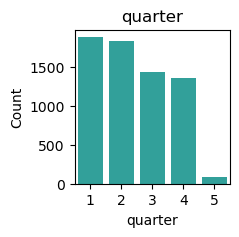

   quarter  Count  Percent
2        1   1877    28.56
4        2   1828    27.81
3        3   1427    21.71
1        4   1353    20.58
5        5     88     1.34
_________________________________________________________________


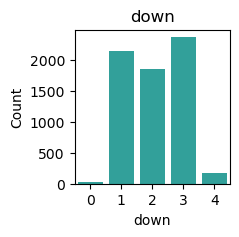

   down  Count  Percent
1     3   2371    36.07
2     1   2145    32.63
3     2   1861    28.31
4     4    168     2.56
0     0     28     0.43
_________________________________________________________________


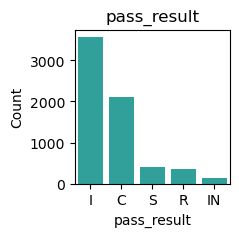

   pass_result  Count  Percent
C            I   3571    54.33
I            C   2097    31.90
S            S    413     6.28
R            R    349     5.31
IN          IN    143     2.18
_________________________________________________________________


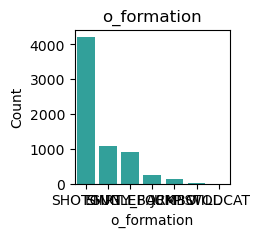

           o_formation  Count  Percent
SHOTGUN        SHOTGUN   4212    64.08
EMPTY            EMPTY   1067    16.23
SINGLEBACK  SINGLEBACK    895    13.62
I_FORM          I_FORM    237     3.61
PISTOL           JUMBO    140     2.13
JUMBO           PISTOL     21     0.32
WILDCAT        WILDCAT      1     0.02
_________________________________________________________________


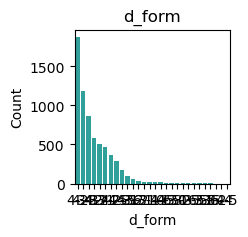

    d_form  Count  Percent
4-2    4-2   1876    28.54
2-4    4-4   1183    18.00
3-3    3-3    862    13.11
2-3    4-3    584     8.88
4-3    3-4    506     7.70
3-4    2-4    463     7.04
4-1    2-2    364     5.54
3-2    1-5    290     4.41
1-4    2-3    169     2.57
1-5    4-1     97     1.48
5-2    3-2     53     0.81
5-1    5-2     28     0.43
2-5    6-1     18     0.27
4-4    3-1     16     0.24
2-2    1-4     15     0.23
1-3    4-6     14     0.21
3-1    0-3     10     0.15
0-3    1-3      4     0.06
5-3    5-1      4     0.06
4-6    5-3      3     0.05
6-3    0-5      3     0.05
6-1    2-5      2     0.03
0-5    6-3      2     0.03
5-5    3-5      2     0.03
1-2    5-5      2     0.03
3-5    1-2      1     0.02
6-4    6-4      1     0.02
4-5    4-5      1     0.02
_________________________________________________________________


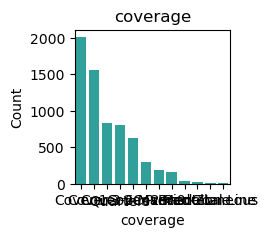

                    coverage  Count  Percent
Cover-3              Cover-1   2010    30.58
Cover-1              Cover-3   1561    23.75
Cover-2              Cover-6    829    12.61
Quarters            Quarters    811    12.34
Cover-6              Cover-2    629     9.57
Red Zone               2-Man    294     4.47
Cover-0              Cover-0    189     2.88
2-Man                Prevent    165     2.51
Bracket              Bracket     37     0.56
Prevent             Red Zone     25     0.38
Goal Line      Miscellaneous     15     0.23
Miscellaneous      Goal Line      8     0.12
_________________________________________________________________


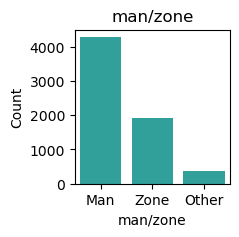

      man/zone  Count  Percent
Zone       Man   4279    65.10
Man       Zone   1915    29.13
Other    Other    379     5.77
_________________________________________________________________


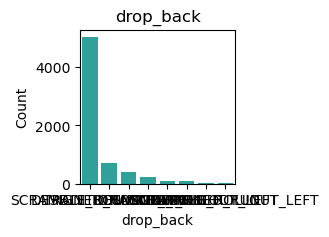

                                     drop_back  Count  Percent
TRADITIONAL                        TRADITIONAL   5034    76.59
SCRAMBLE                SCRAMBLE_ROLLOUT_RIGHT    692    10.53
UNKNOWN                 DESIGNED_ROLLOUT_RIGHT    411     6.25
DESIGNED_ROLLOUT_RIGHT                 UNKNOWN    214     3.26
DESIGNED_ROLLOUT_LEFT                 SCRAMBLE    102     1.55
SCRAMBLE_ROLLOUT_RIGHT   DESIGNED_ROLLOUT_LEFT    100     1.52
SCRAMBLE_ROLLOUT_LEFT             DESIGNED_RUN     15     0.23
DESIGNED_RUN             SCRAMBLE_ROLLOUT_LEFT      5     0.08
_________________________________________________________________


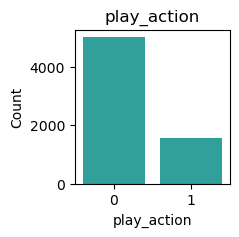

   play_action  Count  Percent
0            0   5014    76.28
1            1   1559    23.72
_________________________________________________________________


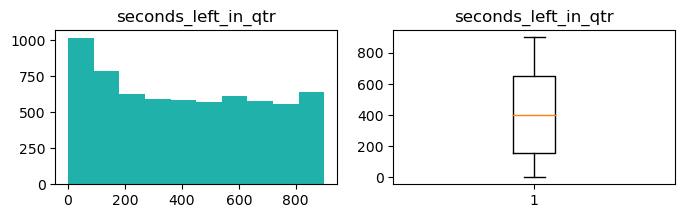

count    6573.000000
mean      413.604595
std       273.949315
min         0.000000
25%       156.000000
50%       399.000000
75%       650.000000
max       900.000000
Name: seconds_left_in_qtr, dtype: float64


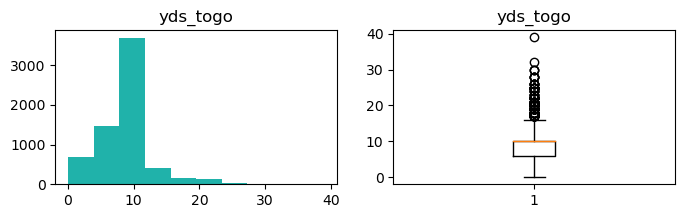

count    6573.000000
mean        8.723718
std         3.952361
min         0.000000
25%         6.000000
50%        10.000000
75%        10.000000
max        39.000000
Name: yds_togo, dtype: float64


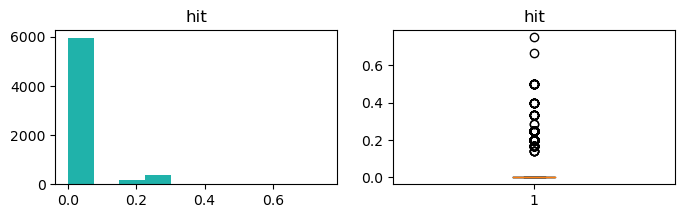

count    6573.000000
mean        0.022352
std         0.073031
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.750000
Name: hit, dtype: float64


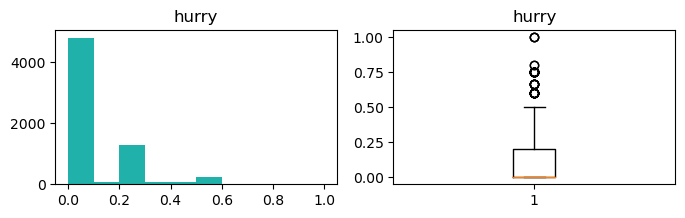

count    6573.000000
mean        0.078100
std         0.142682
min         0.000000
25%         0.000000
50%         0.000000
75%         0.200000
max         1.000000
Name: hurry, dtype: float64


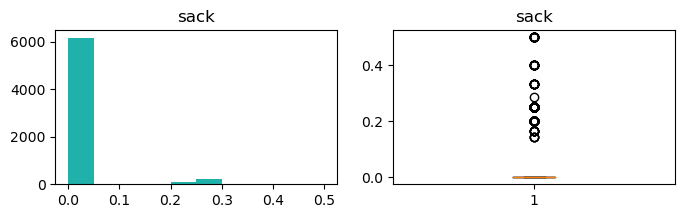

count    6573.000000
mean        0.015831
std         0.065283
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.500000
Name: sack, dtype: float64


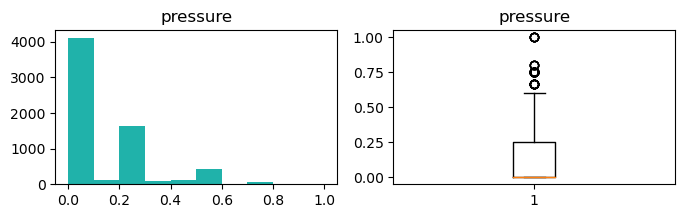

count    6573.000000
mean        0.116283
std         0.172950
min         0.000000
25%         0.000000
50%         0.000000
75%         0.250000
max         1.000000
Name: pressure, dtype: float64


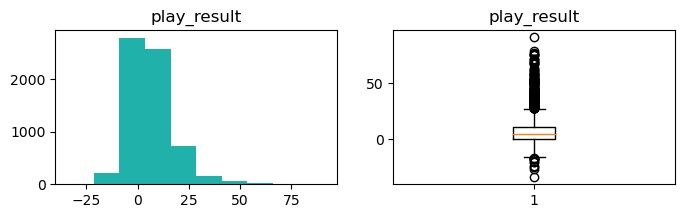

count    6573.000000
mean        6.673665
std        10.693689
min       -34.000000
25%         0.000000
50%         5.000000
75%        11.000000
max        91.000000
Name: play_result, dtype: float64


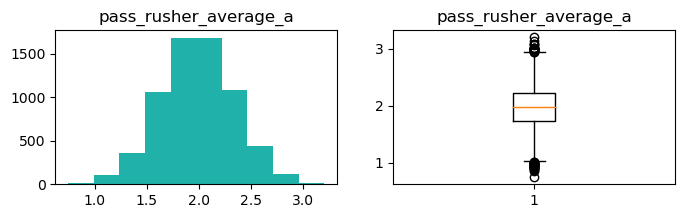

count    6573.000000
mean        1.982018
std         0.353654
min         0.745500
25%         1.741550
50%         1.980375
75%         2.221920
max         3.202000
Name: pass_rusher_average_a, dtype: float64


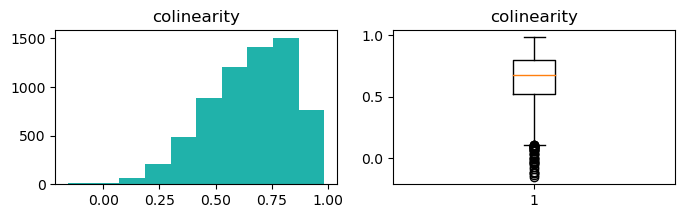

count    6573.000000
mean        0.651151
std         0.188465
min        -0.157175
25%         0.523900
50%         0.675650
75%         0.801040
max         0.983525
Name: colinearity, dtype: float64


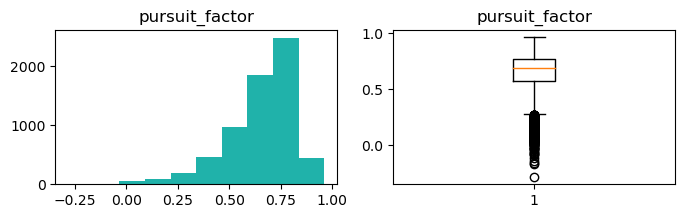

count    6573.000000
mean        0.653349
std         0.165759
min        -0.284067
25%         0.573460
50%         0.692175
75%         0.772450
max         0.961475
Name: pursuit_factor, dtype: float64


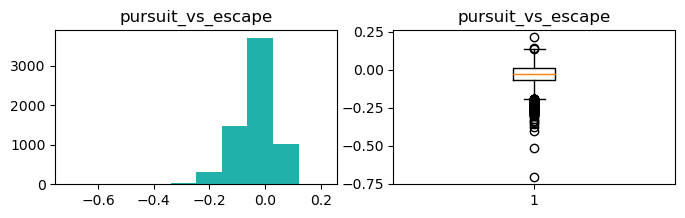

count    6573.000000
mean       -0.034198
std         0.066931
min        -0.707425
25%        -0.069950
50%        -0.025625
75%         0.012000
max         0.212375
Name: pursuit_vs_escape, dtype: float64


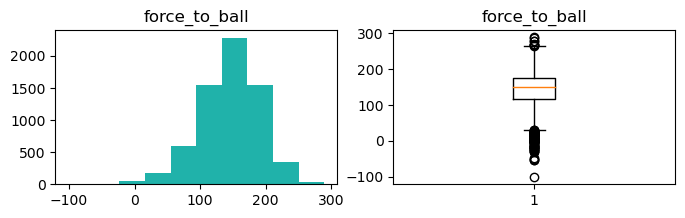

count    6573.000000
mean      145.689979
std        45.701767
min      -101.448333
25%       117.665950
50%       149.370150
75%       176.642600
max       289.082220
Name: force_to_ball, dtype: float64


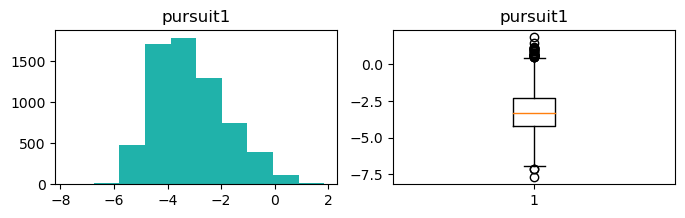

count    6573.000000
mean       -3.161852
std         1.334205
min        -7.715450
25%        -4.182700
50%        -3.342000
75%        -2.319560
max         1.854150
Name: pursuit1, dtype: float64


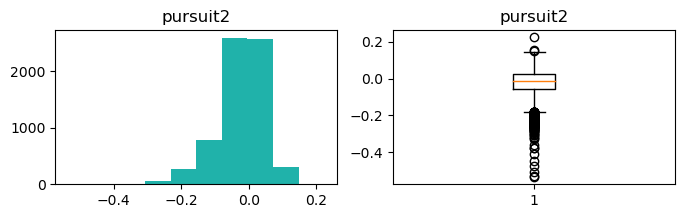

count    6573.000000
mean       -0.022545
std         0.069190
min        -0.534725
25%        -0.057725
50%        -0.012640
75%         0.024375
max         0.223500
Name: pursuit2, dtype: float64


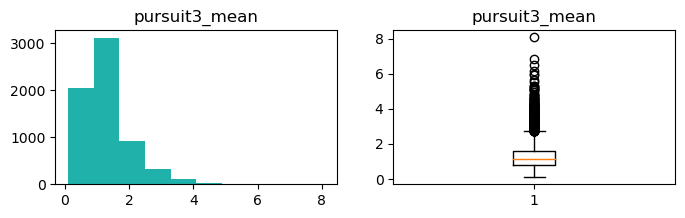

count    6573.000000
mean        1.301239
std         0.742111
min         0.099500
25%         0.814025
50%         1.133300
75%         1.576340
max         8.076800
Name: pursuit3_mean, dtype: float64


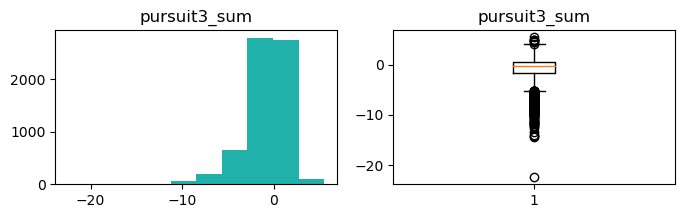

count    6573.000000
mean       -0.800145
std         2.277932
min       -22.458850
25%        -1.682150
50%        -0.331825
75%         0.642700
max         5.502175
Name: pursuit3_sum, dtype: float64


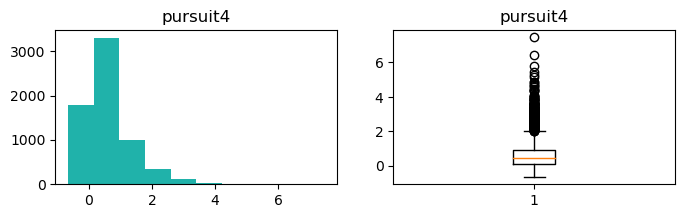

count    6573.000000
mean        0.614530
std         0.745293
min        -0.662500
25%         0.122875
50%         0.442233
75%         0.892960
max         7.463700
Name: pursuit4, dtype: float64


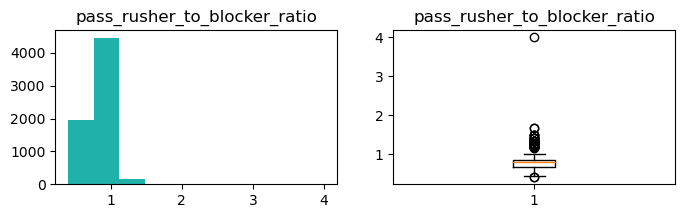

count    6573.000000
mean        0.801401
std         0.146941
min         0.400000
25%         0.666667
50%         0.800000
75%         0.833333
max         4.000000
Name: pass_rusher_to_blocker_ratio, dtype: float64


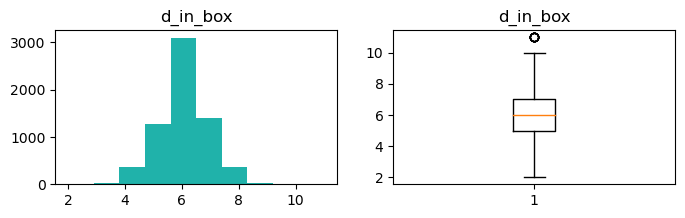

count    6573.000000
mean        6.023277
std         0.990171
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        11.000000
Name: d_in_box, dtype: float64


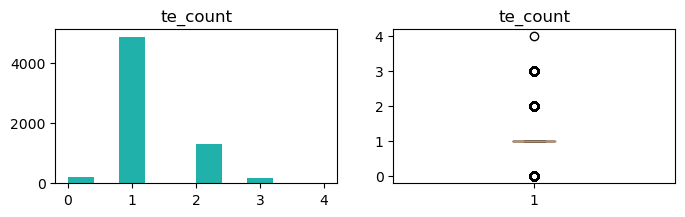

count    6573.000000
mean        1.217252
std         0.541037
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: te_count, dtype: float64


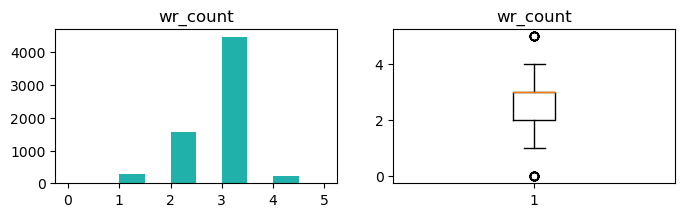

count    6573.000000
mean        2.703788
std         0.622205
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: wr_count, dtype: float64


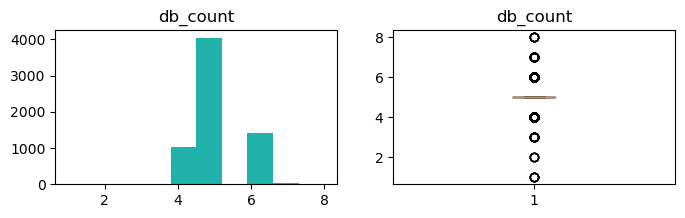

count    6573.000000
mean        5.058573
std         0.659041
min         1.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         8.000000
Name: db_count, dtype: float64


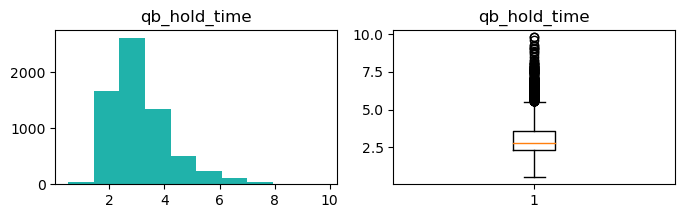

count    6573.000000
mean        3.108915
std         1.134851
min         0.500000
25%         2.300000
50%         2.800000
75%         3.600000
max         9.800000
Name: qb_hold_time, dtype: float64


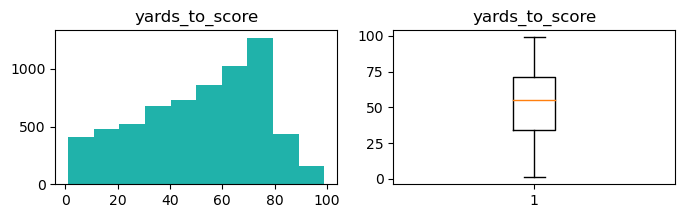

count    6573.000000
mean       51.588316
std        23.513713
min         1.000000
25%        34.000000
50%        55.000000
75%        71.000000
max        99.000000
Name: yards_to_score, dtype: float64


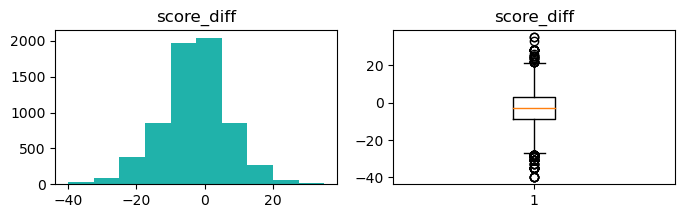

count    6573.000000
mean       -3.208428
std         9.688361
min       -40.000000
25%        -9.000000
50%        -3.000000
75%         3.000000
max        35.000000
Name: score_diff, dtype: float64


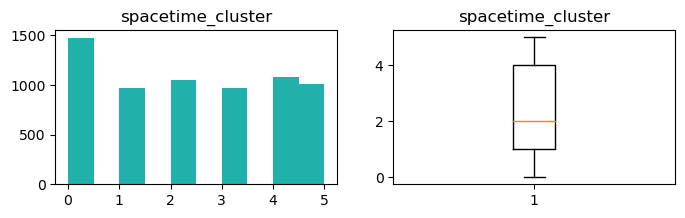

count    6573.000000
mean        2.343831
std         1.768173
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         5.000000
Name: spacetime_cluster, dtype: float64


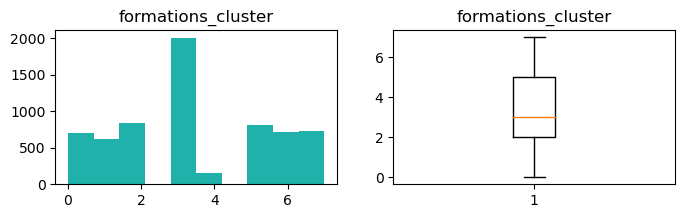

count    6573.000000
mean        3.405294
std         2.140966
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max         7.000000
Name: formations_cluster, dtype: float64


In [210]:
explore_univariate(train, cat_vars, quant_vars)


In [212]:
from scipy import stats

In [ ]:
for i in train.columns:
    print(train[i])

quarter 
_____________________



TypeError: Could not convert ICCIICICCCCCCCCCCIICCCCCCICICIICCIICCCCCICISRRIIINCCCIICCIIIINCCCCCCCRCCCIIIICCCCCCCICCCCCICCCICIIICCCICCIICCCIRCIIICCIIICICCCCCCICIRCRRCCCSCICCICCCCICIICCCCIICCCCISRICSISCIIRCCICCIICSICCICCCIIIISCSICICCCCCCICINCICICCIIIIIICICCIRICICISCCICRCIIIICCSCCCIICSIIICCCIIICCCICIINCIIICCCICICSCCCCCISIIIICCIISCIICCCCCIISICCCCCIICCSCCICCCICIISCCSSIICCCCCSCICICCCCCCCCCICCCICCCICSCIICIICICCCISICSCCICCCCCSICIICCCCICIICCCIISCCCCCCCCCCCCCCCCINSCICRICCIIIIICRICCCCISICSCCCCICIICCCIIICCCCCICCCRCCCCICICIRIIIIICISCCCCCICCICICIIICCICCIICINIINIIIRIIICCCCICICCCCCCCIICIIRICCIIICINISCCCICCICICISCCCRRRICSCCCCCCCCCICICSCICICCIIISCSISCCICICCICSCCCCRICICCCRCICICCCCISICCICCSSCICCCIICRIICRCCCRCCCIIIIINCCCICCINIISSCICICIIISCCCSCICCCCCCIICCRICIIISCCCCIIIIICICICCCCISIICCRRCCCCCCIICICSCCCCICINICCRCCCCCCCCIRCICCCCCICICCCCCICICCCRCCRCCIIICIIISCCIRCRCCCSICCCSCICCICCISCCINSCCCCCSCCICICCIICIICICICSCCCCISICCCCICCCICCCIICCCCCCCCICINCCCCRRIICCIICCIRCSCICCCCCIICCIIINCIIICINCICIIINCICCCIICIISCCCCICCIRCICCCCCCCRCICCCCCCICICICSCICICICCRICRSRRIRCIIIIICCCCIISICCCCCCCINCCCCICICCCICCSCCIICISCCCRCCCCCICCCCICCCCCCCRCSICIICICCCIIISICRCIIRCRCISIIICICIIICSCCICCCCICICCICIICCIISIIIICIRIRCICCCCCCSISCCRCCCCCCCIICCCCRRCCCCICIINICISCISCRSCICIICCCCCCISIICCCICCCCCCCRCCCCCCCIIICCCICICRCCCSCCRCICCIRCCICIIINICICCICCCCCCSCICICICICCCCICSCCCCCCICCIIINCRCIICCISSRIINRCRCCCISIICICCCISICCINICCCICCCCICCIISICIRRCCICCSCCCCRCSCISCISISCIRSCCCRICININICCINICICCINCCSCCCCCCCCSCRCIINCCRICCRIICCCCINRICICICCCRRIIICCCICISRICCSCCCCSCCCIINCCCCCCRCIICICRCCIIIISIIRCIRRCSIICCIRIICCCCIICCCIINICCIIICCCICCCSCCCIICCIICIIIICCCICCCCCIIRIIIICICCCCSSSCCRCICIICIRICINIICSSIIICRCICSCIINIICCRCCICICCIINSCRCCCIRCIIIICICCIICCCCCRISCCCCIIIIISSCCIRCICIICCCCCSININCSSINCICICCCICICIRCINCRCICSCCICCCICIICIIICCISIIICIICISCSCCCIIICCCCICIRCCICCIICCIICCCCSICRIRCIICCCRIIIRSCRRCCCCCIICCICINCSCCCSCIIRCICCCCCCICCCCCICCIIICSCCCSCCCCCIICCCCICICCCIICCCCCCIICCCCICCRICCRCRCICCSCCCCCICCINCCCICCINIIICCRSCICCCICIICISCCIICCCICCICCICSCCICIICRCICCCICICIICCCCCSCCCCCICIIINICRICCICCICCCCISICCCCISCCCCCCINCCCIICINIICCICCICCINCINCCCCCINCCCCCCICICCSCCRCIICCICCCICSCCIICCCCIINCISCCRCISCCCCCCIRCCICICCCCIICCISSCCRSCCSCIICCCIICCCICCCCCIICCICCCCIRISCIICCCCCCCCIRCIIIIISIINCCCCIINCICCCCIIICCICCCCCCCCCCCCCCRICCSCINRCCICCIISCIICCCCCCCCRCCCIICSCRCCCCCCIICSCCCCICIICIICCRCICCCCCCSIRINICCCCICIICIIICCCCSCCCICICIISISCICCCCCCCSICCCIIIIICRCCSRCCICICCCICICSCICCICICCICRCCCCCCCICICICICCCCINICCIRCCIRCCIINCIICCCCCICCCICCCIINIISIIIICRCRCRCICIRCCRIICIRISRICCCCSSCCRISSICCSCSCCCCICIISRCSRISSICIINSCCIIIIIIIISIISICIICSCCCCIRRCRIRICIRCIISCSICCCICICCCICCIICCCCCCCRCICIIICCCSINCCSISCICICICCCCICCICCCINRRCCIRCCCCCCRCCINIRCCICIICCCRCCCCCSCCCCCCCIICCSCIRRCINCCIRICCCICCCCCCCCSCCCICCICCICIICICCIISICCRCICICCCCCCCCRIRICIIIINICCIIICIRIIIIIICCICSCCCCICIIRICCIICCSCIIINSCCRCINCICCCCCICCCCCRIICCSRSIIRCICCRCCICCICCIIIINCICCRCCRSRCICCIICCICCICCCICCCIICICCCICCCICSCCIRSICCIICIRCCCCCCCCSCCIICCCIISCIIRCINIINCCCSICCIRCCSCCCCCICCIICCCCCICINCCCIICICCCCCCCIICCSCCICIICCCCCCSCICSIRCICICICICICIINCCCCCIINSICCICICIIIIRCCISCCCIICIICCCIISCCCCIICIICICCCCISCICICCCCICICSSIRCCICSIIICSCICRCCCICCCCCCIINCCIISCICINISICRCCCCICIICIICCICCISCCCCICCCISRCCCICCICCCCICIICICCICICCCRRCSCICIICSCCCIICCCCIRCCCIIICIICIICICCIIICCIICCCICCICCICCCCCCCICICCCICSCICCCICCCICICCCCRSICICCIIICCCCIICISCCCCCCIRSCCCCCICCCCRCCRIIICCSCCCCICICCICCCCCCCCICCISCICCCICCICCCISRIICCCICRCCICCCCIICSINCIICCCCSCIICCCICCIIIIICCCICIICCICSSICCIIICSIIIICICCCCICCCCCINSCIICCICICCICCCRIIISCCIINIRSIRCRRCCCSCIICIRSCRCCCISCCCCCCCCIRSICICCCIRIIICSICCCCCCICICCICCCCICCCCSCCCCICCCCRICSCCCCCCCCCIIICIISRCCCCCCICICSRCRIIICICICCCICCICICIICIICCCISCCCIICRRCICCIIICICCCIRIRINIIINCCCSCISICISCISRCCICICICICIICRCCCCRCINCICICCCCCCCIRCICCIRIIIIICSICIINIIICCCICSICCCCCIICCSCCCSSCICCIICICIISCCIICCCICCRCCCICIRCCIICCSCCIIISCIICISCCIICINCIINSCCICCCCCICCIRICICCCRCCICIICSCCRCCCSCCSIIICCCCCICIICICCISCICCCICCICCSICIICCCSCCCCCCCCCCCRCCIICISCIICIICCICIIICICCIICIIICSSRCIIICRCSCCIICICSIINCIICCIIIIICINIICICIRIIICIICICCCCICICCCCCCCCIRINCCCCCCCICCINCICCCCCCICICCICIIICRCCCIRSIIISICCCINCISIICCCCISCCCCCCSCCICCISCCCICCIICCSCIIIICRICICCIIIIICCCCICICICCSCCCCICIICCIRCCCCCCCRCSRRCCCICRCICCIICICCICSSRINCCICICCCCCCCSCICRCICISIICCCIRCICCCCIIICSINCCCCCCCCCCCCCIRIICIIIIIICCIICCRICCSISIICCISINCIRRCCCIICICICRIRICCCCCICCCCCCCSIISCCCSIICIIICCCCICRIIICRCCCCIICIISIIRIRCIRICRCRICCCIIIRCIISIICIICICIIRCCICCISCICCCCCIICIISISCICSICISIICICCICCCSICCICICCIRCCCCIISCCCCIINCCCCCCSIIIICICICRISCCCCIICICIIIIIICSICCIIIICCICCCCICSCCIIICCICCIICSCINCCCSIICCIICICCIICIINICCIICCICICCICCCSICSCCCCIIIICCCISSICCCCCCCCIRICIICCCIIICCCIIICCICICCCCCCIIIICSSICSCICCCCICIICCCCCCICCCCCCCCCSCCIICICICCCIIICSICRCICCIRINIRIICICCICCIICISCCINRINICICCCCCCICCCCCSCICIICIICCCCSCIICRCCCCCCCICCIIIIIINIRCCIIICCIRICCCCCICCCICIINCCCIICICCICCIIIICCCIICICICCCICCCCCCCCCICCCCCCSCCICCICISICRIIIINCCICICCCICIICCIISICCSCCCCICICCIIRCSININCSSCCCICICCCRICIIIICCIICIINIICCCINISCIIIICCCCCCCCCCCSCCISIRCCCCCCCSCINCCCCCCICIIRCICCICCIICCICICCINCISCIIICCCCCCCCCCCRIICCISSCCIIICCIINCIICCICCCICCCSCCSCICIICICCICCCCCRICIICCCCCCCCIICISICSCCCISICRSIRIIICIIISCICCICCCCIINCICIIICICCICIISSRICCCCCCCCCCCCICIICSCCIICICCCICCCCSICCCICSSICCIICCCCCCICCCICSCCIIIIICSCIICIIICCCCICCICIIICCSCCICCISRCCCCCICCCCICICIINCICICCCICCISCCCICCISCICCICCICICICICCICCCCCSICRCICCICCCICIICSCCCIICCCINCCICISCICCIINIICCCCRIISSCIRCCCICCCCCINIIIRIIIRSICIIIICCCIIIICCICIRIIINCICICISCRRIICCCCIIIIIICCSCCRIICCICRICCCCIISRCIICCCCIIIICRCRCCSIIRIICCCCICIICICCCCICCCCIIIICIICCCICICSCICCISIICINIIICCSICCCCCRCCCISIICCSICICCIRRCINCCIISCRCICISICICIICICICCSICICCCCCSIICIRCCIICRRCIIICCCIICIINRIICCIIIIRICICCCIICCCCCCCSCCICCRICCIICINCISCCCICCICCCCICCICIICCIICINCIIRIIRICRICRIIRCICCSCICCCCICIIRIICICCRICCICIICCICCIIIINICCICCCICCCICCRINRICCICCCRICICCSIIICICCCSRCCSRCCCCCICCIICIICCCCCSCRCCICCCICCCRCCICCCCCCCCSICCCRICCRCCCICRCCCCCCCCICIRICICCCCCCICRIICINICCCIRIIIINIIRCICCCCICIRICCICSICCCICICCCCCCICICCRCCICCCCICICIICICCICCCCCIIIICCIICCICCCICICRRCCCICRCSINCCICCCCICICICICCICIICICCCCCCIIICCCRCSCCRCIICCICIISRRCININCCSISCCIIIIIICCICCCCICICCICINICCSIINCCICIIICCCICSICCCIIIICICICIIRIICIIICSISIICIICICCICICIRISISIRCCIICIIICCRICICCCRCCCICCRCISCCCISCIRIINICCISICRCCISIRCICCCCCIIIISCCRCCCCICCRIRCSSICIRCIRCCCRCCINSINCCCCIICSCCCCICIRCICIICRIRCCCCCCIICIICCSCCCCCCICCCIIICCCCCICCCIICCICSICCCCSCICICIICCCICCICCICCICISRSINCICICRCCIIIICCCCCCICINSCCCIICCISCCIRIICICSCCCCIICCIIIRINCCICICCCINCINCCCCSCINCRCISIIINICICCCIICCCCCCICICIICCCSCCCICICICCCINCIIICCCCICIRIIIIICCCCICCCCICICCSICCCCCIICCCICRCIICCIRICICCSCCCCINICIICCCICCIRSCIIIICISICINSCRCCCCCIICCCSCCSSIICCSICCCICCCRIICICCIICICCSCICCCCIICINCISCICICCRISCICCCCICCCCICCSCIICCCSIIICCRICCCCCCICCICCICIINCCCCCCCCSCINCCCCCCCCCCCCCICCCCIINCCCSCCICCCCCSCICCCCCICICCCIICICIIRINCCICCCCIICICICCCCCCCICICCICCCICICCICCSICCCCICIISCICCCCCCCIISCIICIICCCCCCCCCSCCSIIICRRCIICSCCINCCICISCCCCICIINICCRICCCCCICIICCCICCICICCCCCCCIICCCCCCCCIR to numeric

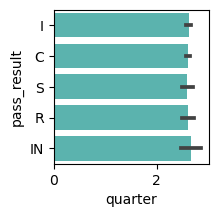

In [213]:
explore_bivariate(train, target, cat_vars, quant_vars)

# explore_multivariate(train, target, cat_vars, quant_vars)

# Some hypothesis testing

1. Completion
2. Scramble for gain
3. Incomplete - No pressure
4. Incomplete - Hurry
5. Incomplete - Hit
6. Sack

In [ ]:
C = C[C.play_count > 10]

In [ ]:
C.sort_values('pursuit_magnitude')

In [ ]:
scout_pass_block

In [ ]:
E = scout_pass_block.groupby('nflId').mean()
B = players[['nflId','displayName']]
E = E.replace(B.set_index('nflId')['displayName'])
E

In [ ]:
E = pd.merge(E, B, on = 'nflId')

In [ ]:
E[['displayName','beaten_by_pass_rusher', 'hit_allowed', 'hurry_allowed', 'sack_allowed', 'block_fail']].set_index('displayName')


In [ ]:
Z = pd.merge(C,E, left_on = 'pass_blocker', right_on = 'displayName').set_index('displayName')

In [ ]:
Z[['hit', 'hit_allowed', 'hurry', 'hurry_allowed', 'sack', 'sack_allowed', 'pressure', 'beaten_by_pass_rusher',
   'block_fail']]

In [ ]:
Z.sort_values(by = 'pursuit4', ascending = False).head(25)

# ---------=====---------

In [ ]:
plays.columns

In [ ]:
plays.head

In [ ]:
plays[plays['man/zone'] == 'Other'].coverage.value_counts()

In [ ]:
dfpa_m['o_personnel'] = te_count

In [ ]:
dfpa_m = dfpa_m.rename(columns = {'o_personnel':'te_count'})

In [ ]:
dfpa_m

In [ ]:
dope

In [ ]:
dope['score_dff'] = dope.o_score - dope.d_score

In [ ]:
dopeX = dope.drop(columns = ['o_score','d_score'])

In [ ]:
dopeX.head(2)

In [ ]:
dopeX.columns